In [2]:
import pandas as pd
import numpy as np
import math
import helper
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut, ShuffleSplit, train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectPercentile, SelectFromModel
import pickle    


In [3]:
# # Общая функция для удобного обучения и предсказания на контрольных данных
# def get_main_df_for_predict_for_ProTeams(df_rating_teams_Premium, df_contrpick, df_meta_heroes):
    
# # -------- Создание основного ДФ -----------------------------------------------
       
#     # Соединение всех данных в один ДФ
#     main = df_rating_teams_Premium
#     main = pd.merge(main, df_contrpick, left_on='match_id', right_on='match_id',how='left')
#     main = pd.merge(main, df_meta_heroes, left_on='match_id', right_on='match_id',how='left')

#     # удаление не нужных колонок для обучения
#     main = main.drop(['radiant_win', #'match_id', 
#                 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
#                'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)


    
#     # Выбросить весь рейтинг команд
#     main = main.drop(main.loc[:, 'radiant_current_elo32':'dire_ratingSevenDaysAgo_glicko2'], axis=1)
#     print (len(main))
    
# # -------- Заполнить или удалить NaN и добаить коллонку с предсказаниями, обучеными ранее -----------------------------------------------       
#     # Заполнить пустые значения на 0
#     # main = main.fillna(0)

#     # убрать пустые ячейки
#     main = main.dropna()
#     print(len(main))
    
# # -------- Создаем новых колонок по суммам, разности показателей -----------------------------------------------    
#     #------------- Для контрпиков героев --------------------------------------------------------
#     main['radiant_elo_vs_enemies'] = (main['radiant_H1_elo_vs_enemies'] + main['radiant_H2_elo_vs_enemies'] + 
#                 main['radiant_H3_elo_vs_enemies'] + main['radiant_H4_elo_vs_enemies'] + main['radiant_H5_elo_vs_enemies'])

#     # main['dire_elo_vs_enemies'] = (main['dire_H1_elo_vs_enemies'] + main['dire_H2_elo_vs_enemies'] + 
#     #                   main['dire_H3_elo_vs_enemies'] + main['dire_H4_elo_vs_enemies'] + main['dire_H5_elo_vs_enemies'])

#     #  main['elo_vs_enemies'] = main['radiant_elo_vs_enemies'] - main['dire_elo_vs_enemies']
#     # main = main.drop(['radiant_elo_vs_enemies', 'dire_elo_vs_enemies'], axis=1)

#     #------------- Для метовых героев --------------------------------------------------------
#     main['radiant_H_AvgElo'] = (main['radiant_H1_AvgElo'] + main['radiant_H2_AvgElo'] + 
#                               main['radiant_H3_AvgElo'] + main['radiant_H4_AvgElo'] + main['radiant_H5_AvgElo'])

# #     main['dire_H_AvgElo'] = (main['dire_H1_AvgElo'] + main['dire_H2_AvgElo'] + 
# #                                main['dire_H3_AvgElo'] + main['dire_H4_AvgElo'] + main['dire_H5_AvgElo'])

# #     main['H_AvgElo'] = main['radiant_H_AvgElo'] - main['dire_H_AvgElo']

#     # main = main.drop(['dire_H_AvgElo', 'radiant_H_AvgElo'], axis=1)
# # -------- Убрать лишние колонки -----------------------------------------------  
# #     main = main.drop(['dire_H5_AvgElo',
# #                      ], axis=1)
#     return main

In [75]:
# Общая функция для удобного обучения и предсказания на контрольных данных
def get_main_df_for_predict(df_rating_teams_Premium, df_contrpick, df_meta_heroes, 
                            df_features_Heroes, df_features_type_Heroes, df_predict_for_teams_rating,
                            df_meta_7day_ago, 
                           df_KDA_heroes, df_KDA_heroes_7day_ago, df_KDA_players_on_hero, df_KDA_players_7day_ago):
# -------- Создание ДФ с логарифмами произведений ---------------------------------------------------
    df_LN_heroes = pd.DataFrame()
    for team in ['radiant', 'dire']:
        for i in range(1,6):
            df_LN_heroes[team + '_H' + str(i) + '_LN_heroes'] = (np.log(df_KDA_heroes[team + '_H' + str(i) + '_gpm'] *
                    df_KDA_heroes[team + '_H' + str(i) + '_xpm'] *
                    df_KDA_heroes[team + '_H' + str(i) + '_kda']) *
                    df_KDA_heroes[team + '_H' + str(i) + '_winrate'])
    df_LN_heroes['match_id'] = df_KDA_heroes['match_id']
    df_LN_heroes = df_LN_heroes.fillna(0)
    
    df_LN_heroes_7day_ago = pd.DataFrame()
    for team in ['radiant', 'dire']:
        for i in range(1,6):
            df_LN_heroes_7day_ago[team + '_H' + str(i) + '_LN_heroes_7day_ago'] = (np.log(
                    df_KDA_heroes_7day_ago[team + '_H' + str(i) + '_gpm'] *
                    df_KDA_heroes_7day_ago[team + '_H' + str(i) + '_xpm'] *
                    df_KDA_heroes_7day_ago[team + '_H' + str(i) + '_kda']) * 
                    df_KDA_heroes_7day_ago[team + '_H' + str(i) + '_winrate'])
    df_LN_heroes_7day_ago['match_id'] = df_KDA_heroes_7day_ago['match_id']
    df_LN_heroes_7day_ago = df_LN_heroes_7day_ago.fillna(0)

    df_LN_players_on_hero = pd.DataFrame()
    for team in ['radiant', 'dire']:
        for i in range(1,6):
            df_LN_players_on_hero[team + '_P' + str(i) + '_LN_players_on_hero'] = (np.log(
                    df_KDA_players_on_hero[team + '_P' + str(i) + '_gpm'] *
                    df_KDA_players_on_hero[team + '_P' + str(i) + '_xpm'] *
                    df_KDA_players_on_hero[team + '_P' + str(i) + '_kda']) *
                    df_KDA_players_on_hero[team + '_P' + str(i) + '_winrate'])
    df_LN_players_on_hero['match_id'] = df_KDA_players_on_hero['match_id']
    df_LN_players_on_hero = df_LN_players_on_hero.fillna(0)

    df_LN_players_7day_ago = pd.DataFrame()
    for team in ['radiant', 'dire']:
        for i in range(1,6):
            df_LN_players_7day_ago[team + '_P' + str(i) + '_LN_players_7day_ago'] = (np.log(
                    df_KDA_players_7day_ago[team + '_P' + str(i) + '_gpm_7day_ago'] *
                    df_KDA_players_7day_ago[team + '_P' + str(i) + '_xpm_7day_ago'] *
                    df_KDA_players_7day_ago[team + '_P' + str(i) + '_kda_7day_ago']) *
                    df_KDA_players_7day_ago[team + '_P' + str(i) + '_winrate_7day_ago'])
    df_LN_players_7day_ago['match_id'] = df_KDA_players_7day_ago['match_id']
    df_LN_players_7day_ago = df_LN_players_7day_ago.fillna(0)

# -------- Создание основного ДФ -----------------------------------------------
    df_signatures_heroes = df_KDA_players_on_hero[['radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift', 
                                                    'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift', 
                                                    'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift', 
                                                    'dire_P5_eloShift', 'match_id']]
    df_eloShift_players_7day_ago = df_KDA_players_7day_ago[['radiant_P1_eloShift_7day_ago', 'radiant_P2_eloShift_7day_ago', 
                        'radiant_P3_eloShift_7day_ago', 'radiant_P4_eloShift_7day_ago', 'radiant_P5_eloShift_7day_ago', 
                        'dire_P1_eloShift_7day_ago', 'dire_P2_eloShift_7day_ago', 'dire_P3_eloShift_7day_ago', 
                        'dire_P4_eloShift_7day_ago', 'dire_P5_eloShift_7day_ago', 'match_id']]
    
#     df_features_Heroes = df_features_Heroes[[ 'Clockwerk', 'Gyrocopter', 'Io', 'match_id']]
    
    # Соединение всех данных в один ДФ
    main = df_rating_teams_Premium
    main = pd.merge(main, df_contrpick, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_meta_heroes, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_signatures_heroes, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_meta_7day_ago, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_eloShift_players_7day_ago, left_on='match_id', right_on='match_id',how='left')
    # ---------------------------------------------------------------------------------------------------------------------
    # Добавить фичи по геряом и типам героев
#     main = pd.merge(main, df_features_type_Heroes, left_on='match_id', right_on='match_id',how='left')
#     main = pd.merge(main, df_features_Heroes, left_on='match_id', right_on='match_id',how='left')
    # ---------------------------------------------------------------------------------------------------------------------
    # Добавить фичи по предсказаний по алгоритму
    main = pd.merge(main, df_predict_for_teams_rating, left_on='match_id', right_on='match_id',how='left')
    # ---------------------------------------------------------------------------------------------------------------------
    # Добавить фичи по Professional матчам
    # main = pd.merge(main, df_contrpick_Pro10, left_on='match_id', right_on='match_id',how='left')
    # main = pd.merge(main, df_contrpick_2MonthAgo_AllTeam1, left_on='match_id', right_on='match_id',how='left')
    # ---------------------------------------------------------------------------------------------------------------------
    # Добавить фичи логарифму произведения XPM GPM KDA и винрейт
    main = pd.merge(main, df_LN_heroes, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_LN_heroes_7day_ago, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_LN_players_on_hero, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_LN_players_7day_ago, left_on='match_id', right_on='match_id',how='left')
    # ---------------------------------------------------------------------------------------------------------------------
    # удаление не нужных колонок для обучения
    main = main.drop([#'match_id',
                      'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
               'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
    main = main.drop(main.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)


    # # Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
#     main = main.drop(main.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
#     main = main.drop(main.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_ratingSevenDaysAgo_glicko':'radiant_ratingSevenDaysAgo_glicko2'], axis=1)
#     main = main.drop(main.loc[:, 'dire_ratingSevenDaysAgo_glicko':'dire_ratingSevenDaysAgo_glicko2'], axis=1)
    # Выбросить весь рейтинг команд
    main = main.drop(main.loc[:, 'radiant_current_elo32':'dire_ratingSevenDaysAgo_glicko2'], axis=1)
    print (len(main))
    # Убрать из данных по ссигнатуркам
#     main = main.drop(['radiant_P1_xpm', 'radiant_P2_xpm', 'radiant_P3_xpm', 
#                                 'radiant_P4_xpm', 'radiant_P5_xpm', 'dire_P1_xpm', 
#                                 'dire_P2_xpm', 'dire_P3_xpm', 'dire_P4_xpm', 
#                                 'dire_P5_xpm' ], axis=1)
    
# -------- Заполнить или удалить NaN и добаить коллонку с предсказаниями, обучеными ранее -----------------------------------------------       
    # Заполнить пустые значения на 0
    # main = main.fillna(0)
    
    # убрать пустые ячейки
#     main = main.dropna()
    print(len(main))
    
# -------- Создаем новых колонок по суммам, разности показателей -----------------------------------------------    
    #------------- Для контрпиков героев --------------------------------------------------------
    main['radiant_elo_vs_enemies'] = (main['radiant_H1_elo_vs_enemies'] + main['radiant_H2_elo_vs_enemies'] + 
                main['radiant_H3_elo_vs_enemies'] + main['radiant_H4_elo_vs_enemies'] + main['radiant_H5_elo_vs_enemies'])

#     main['dire_elo_vs_enemies'] = (main['dire_H1_elo_vs_enemies'] + main['dire_H2_elo_vs_enemies'] + 
#                       main['dire_H3_elo_vs_enemies'] + main['dire_H4_elo_vs_enemies'] + main['dire_H5_elo_vs_enemies'])

#     main['elo_vs_enemies'] = main['radiant_elo_vs_enemies'] - main['dire_elo_vs_enemies']
#     main = main.drop(['radiant_elo_vs_enemies', 'dire_elo_vs_enemies'], axis=1)

    #------------- Для сигнатурных героев по игрокам --------------------------------------------------------
    main['radiant_P_eloShift'] = (main['radiant_P1_eloShift'] + main['radiant_P2_eloShift'] + 
                                  main['radiant_P3_eloShift'] + main['radiant_P4_eloShift'] + main['radiant_P5_eloShift'])

    main['dire_P_eloShift'] = (main['dire_P1_eloShift'] + main['dire_P2_eloShift'] + 
                               main['dire_P3_eloShift'] + main['dire_P4_eloShift'] + main['dire_P5_eloShift'])

    main['P_eloShift'] = main['radiant_P_eloShift'] - main['dire_P_eloShift']

#     main = main.drop(['radiant_P_eloShift', 'dire_P_eloShift'], axis=1)

    #------------- Для метовых героев --------------------------------------------------------
    main['radiant_H_AvgElo'] = (main['radiant_H1_AvgElo'] + main['radiant_H2_AvgElo'] + 
                              main['radiant_H3_AvgElo'] + main['radiant_H4_AvgElo'] + main['radiant_H5_AvgElo'])

    main['dire_H_AvgElo'] = (main['dire_H1_AvgElo'] + main['dire_H2_AvgElo'] + 
                               main['dire_H3_AvgElo'] + main['dire_H4_AvgElo'] + main['dire_H5_AvgElo'])

    main['H_AvgElo'] = main['radiant_H_AvgElo'] - main['dire_H_AvgElo']

#     main = main.drop(['dire_H_AvgElo', 'radiant_H_AvgElo'], axis=1) LN_heroes_7day_ago

    #------------- Для LN(kda*gpm*xpm) для игроков за последние 7 дней --------------------------------------------------------
    main['radiant_LN_players_7day_ago'] = (main['radiant_P1_LN_players_7day_ago'] + 
                        main['radiant_P2_LN_players_7day_ago'] + main['radiant_P3_LN_players_7day_ago'] + 
                        main['radiant_P4_LN_players_7day_ago'] + main['radiant_P5_LN_players_7day_ago'])

    main['dire_LN_players_7day_ago'] = (main['dire_P1_LN_players_7day_ago'] + 
                                main['dire_P2_LN_players_7day_ago'] + main['dire_P3_LN_players_7day_ago'] + 
                                main['dire_P4_LN_players_7day_ago'] + main['dire_P5_LN_players_7day_ago'])

    main['LN_players_7day_ago'] = main['radiant_LN_players_7day_ago'] - main['dire_LN_players_7day_ago']

#     main = main.drop(['dire_LN_players_7day_ago', 'radiant_LN_players_7day_ago'], axis=1)

    #------------- Для LN(kda*gpm*xpm) для героев за последние 7 дней --------------------------------------------------------
    main['radiant_H_LN_heroes_7day_ago'] = (main['radiant_H1_LN_heroes_7day_ago'] + 
                            main['radiant_H2_LN_heroes_7day_ago'] + main['radiant_H3_LN_heroes_7day_ago'] + 
                            main['radiant_H4_LN_heroes_7day_ago'] + main['radiant_H5_LN_heroes_7day_ago'])

    main['dire_H_LN_heroes_7day_ago'] = (main['dire_H1_LN_heroes_7day_ago'] + 
                                main['dire_H2_LN_heroes_7day_ago'] + main['dire_H3_LN_heroes_7day_ago'] + 
                                main['dire_H4_LN_heroes_7day_ago'] + main['dire_H5_LN_heroes_7day_ago'])

    main['H_LN_heroes_7day_ago'] = main['radiant_H_LN_heroes_7day_ago'] - main['dire_H_LN_heroes_7day_ago']

#     main = main.drop(['dire_H_LN_heroes_7day_ago', 'radiant_H_LN_heroes_7day_ago'], axis=1)
 #------------- Для метовых героев 7 дней назад --------------------------------------------------------
    main['radiant_H_AvgElo_7day_ago'] = (main['radiant_H1_AvgElo_7day_ago'] + main['radiant_H2_AvgElo_7day_ago'] + 
                              main['radiant_H3_AvgElo_7day_ago'] + main['radiant_H4_AvgElo_7day_ago'] + 
                                         main['radiant_H5_AvgElo_7day_ago'])

    main['dire_H_AvgElo_7day_ago'] = (main['dire_H1_AvgElo_7day_ago'] + main['dire_H2_AvgElo_7day_ago'] + 
                               main['dire_H3_AvgElo_7day_ago'] + main['dire_H4_AvgElo_7day_ago'] + 
                                      main['dire_H5_AvgElo_7day_ago'])

    main['H_AvgElo_7day_ago'] = main['radiant_H_AvgElo_7day_ago'] - main['dire_H_AvgElo_7day_ago']

#     main = main.drop(['dire_H_AvgElo_7day_ago', 'radiant_H_AvgElo_7day_ago'], axis=1)

 #------------- Для того как игрок отыграл 7 дней назад --------------------------------------------------------
    main['radiant_P_eloShift_7day_ago'] = (main['radiant_P1_eloShift_7day_ago'] + main['radiant_P2_eloShift_7day_ago'] + 
                                  main['radiant_P3_eloShift_7day_ago'] + main['radiant_P4_eloShift_7day_ago'] + 
                                           main['radiant_P5_eloShift_7day_ago'])

    main['dire_P_eloShift_7day_ago'] = (main['dire_P1_eloShift_7day_ago'] + main['dire_P2_eloShift_7day_ago'] + 
                               main['dire_P3_eloShift_7day_ago'] + main['dire_P4_eloShift_7day_ago'] + 
                                        main['dire_P5_eloShift_7day_ago'])

    main['P_eloShift_7day_ago'] = main['radiant_P_eloShift_7day_ago'] - main['dire_P_eloShift_7day_ago']

#     main = main.drop(['radiant_P_eloShift_7day_ago', 'dire_P_eloShift_7day_ago'], axis=1)

    #---------- Для рейтинга команд -----------------------------------------------------------
#     main['mu_glicko'] = main['radiant_mu_glicko'] -  main['dire_mu_glicko']
#     main['rating_glicko'] = main['radiant_rating_glicko'] -  main['dire_rating_glicko']
#     main['ratingSevenDaysAgo_glicko'] = main['radiant_ratingSevenDaysAgo_glicko'] -  main['dire_ratingSevenDaysAgo_glicko']
#     main['mu_glicko2'] = main['radiant_mu_glicko2'] -  main['dire_mu_glicko2']
#     main['phi_glicko2'] = main['radiant_phi_glicko2'] -  main['dire_phi_glicko2']
#     main['rating_glicko2'] = main['radiant_rating_glicko2'] -  main['dire_rating_glicko2']
#     main['ratingSevenDaysAgo_glicko2'] = main['radiant_ratingSevenDaysAgo_glicko2']-main['dire_ratingSevenDaysAgo_glicko2']

    # ---------- Для сигнатурных героев -----------------------------------------------------------
#     main['radiant_P_kda'] = (main['radiant_P1_kda'] + main['radiant_P2_kda'] + 
#                                   main['radiant_P3_kda'] + main['radiant_P4_kda'] + main['radiant_P5_kda'])

#     main['dire_P_kda'] = (main['dire_P1_kda'] + main['dire_P2_kda'] + 
#                                main['dire_P3_kda'] + main['dire_P4_kda'] + main['dire_P5_kda'])

#     main['P_kda'] = main['radiant_P_kda'] - main['dire_P_kda']

#     main = main.drop(['radiant_P_kda', 'dire_P_kda'], axis=1)
    #---------------------------------------------------------------------------------------------------
#     main['radiant_P_kda_mean'] = (main['radiant_P1_kda'] + main['radiant_P2_kda'] + 
#                                   main['radiant_P3_kda'] + main['radiant_P4_kda'] + main['radiant_P5_kda'])/5

#     main['dire_P_kda_mean'] = (main['dire_P1_kda'] + main['dire_P2_kda'] + 
#                                main['dire_P3_kda'] + main['dire_P4_kda'] + main['dire_P5_kda'])/5

#     main['P_kda_mean'] = main['radiant_P_kda_mean'] - main['dire_P_kda_mean']

#     main = main.drop(['radiant_P_kda_mean', 'dire_P_kda_mean'], axis=1)
    #---------------------------------------------------------------------------------------------------
#     main['radiant_P_gpm'] = (main['radiant_P1_gpm'] + main['radiant_P2_gpm'] + 
#                                   main['radiant_P3_gpm'] + main['radiant_P4_gpm'] + main['radiant_P5_gpm'])

#     main['dire_P_gpm'] = (main['dire_P1_gpm'] + main['dire_P2_gpm'] + 
#                                main['dire_P3_gpm'] + main['dire_P4_gpm'] + main['dire_P5_gpm'])

#     main['P_gpm'] = main['radiant_P_gpm'] - main['dire_P_gpm']

#     main = main.drop(['radiant_P_gpm', 'dire_P_gpm'], axis=1)
#---------------------------------------------------------------------------------------------------
#     main['radiant_P_gpm_mean'] = (main['radiant_P1_gpm'] + main['radiant_P2_gpm'] + 
#                                   main['radiant_P3_gpm'] + main['radiant_P4_gpm'] + main['radiant_P5_gpm'])/5

#     main['dire_P_gpm_mean'] = (main['dire_P1_gpm'] + main['dire_P2_gpm'] + 
#                                main['dire_P3_gpm'] + main['dire_P4_gpm'] + main['dire_P5_gpm'])/5

#     main['P_gpm_mean'] = main['radiant_P_gpm_mean'] - main['dire_P_gpm_mean']

#     main = main.drop(['radiant_P_gpm_mean', 'dire_P_gpm_mean'], axis=1)
    #---------------------------------------------------------------------------------------------------
#     main['radiant_P_xpm'] = (main['radiant_P1_xpm'] + main['radiant_P2_xpm'] + 
#                                   main['radiant_P3_xpm'] + main['radiant_P4_xpm'] + main['radiant_P5_xpm'])

#     main['dire_P_xpm'] = (main['dire_P1_xpm'] + main['dire_P2_xpm'] + 
#                                main['dire_P3_xpm'] + main['dire_P4_xpm'] + main['dire_P5_xpm'])

#     main['P_xpm'] = main['radiant_P_xpm'] - main['dire_P_xpm']

#     main = main.drop(['radiant_P_xpm', 'dire_P_xpm'], axis=1)

    # Убрать из данных по ссигнатуркам
#     main = main.drop(['radiant_P1_kda', 'radiant_P2_kda', 'radiant_P3_kda', 
#                             'radiant_P4_kda', 'radiant_P5_kda', 'dire_P1_kda', 
#                             'dire_P2_kda', 'dire_P3_kda', 'dire_P4_kda', 
#                             'dire_P5_kda' ], axis=1)
#     main = main.drop(['radiant_P1_gpm', 'radiant_P2_gpm', 'radiant_P3_gpm', 
#                             'radiant_P4_gpm', 'radiant_P5_gpm', 'dire_P1_gpm', 
#                             'dire_P2_gpm', 'dire_P3_gpm', 'dire_P4_gpm', 
#                             'dire_P5_gpm' ], axis=1)
#     main = main.drop(['radiant_P1_xpm', 'radiant_P2_xpm', 'radiant_P3_xpm', 
#                             'radiant_P4_xpm', 'radiant_P5_xpm', 'dire_P1_xpm', 
#                             'dire_P2_xpm', 'dire_P3_xpm', 'dire_P4_xpm', 
#                             'dire_P5_xpm' ], axis=1)

# -------- Создаем новых колонок по разности типов героев -----------------------------------------------        
#     main['Disabler'] = (main['Disabler1'] + main['Disabler2'] + main['Disabler3'] + main['Disabler4'] + main['Disabler5'] - 
#                    main['Disabler6'] - main['Disabler7'] - main['Disabler8'] - main['Disabler9'] - main['Disabler10'])

#     main['Nuker'] = (main['Nuker1'] + main['Nuker2'] + main['Nuker3'] + main['Nuker4'] + main['Nuker5'] - 
#                        main['Nuker6'] - main['Nuker7'] - main['Nuker8'] - main['Nuker9'] - main['Nuker10'])

#     main['Carry'] = (main['Carry1'] + main['Carry2'] + main['Carry3'] + main['Carry4'] + main['Carry5'] - 
#                        main['Carry6'] - main['Carry7'] - main['Carry8'] - main['Carry9'] - main['Carry10'])

#     main['Initiator'] = (main['Initiator1'] + main['Initiator2'] + main['Initiator3']+main['Initiator4']+main['Initiator5'] - 
#                     main['Initiator6'] - main['Initiator7'] - main['Initiator8'] - main['Initiator9'] - main['Initiator10'])

#     main['Escape'] = (main['Escape1'] + main['Escape2'] + main['Escape3'] + main['Escape4'] + main['Escape5'] - 
#                        main['Escape6'] - main['Escape7'] - main['Escape8'] - main['Escape9'] - main['Escape10'])

#     main['Durable'] = (main['Durable1'] + main['Durable2'] + main['Durable3'] + main['Durable4'] + main['Durable5'] - 
#                        main['Durable6'] - main['Durable7'] - main['Durable8'] - main['Durable9'] - main['Durable10'])

#     main['Support'] = (main['Support1'] + main['Support2'] + main['Support3'] + main['Support4'] + main['Support5'] - 
#                        main['Support6'] - main['Support7'] - main['Support8'] - main['Support9'] - main['Support10'])

#     main['Pusher'] = (main['Pusher1'] + main['Pusher2'] + main['Pusher3'] + main['Pusher4'] + main['Pusher5'] - 
#                        main['Pusher6'] - main['Pusher7'] - main['Pusher8'] - main['Pusher9'] - main['Pusher10'])

#     main['Jungler'] = (main['Jungler1'] + main['Jungler2'] + main['Jungler3'] + main['Jungler4'] + main['Jungler5'] - 
#                        main['Jungler6'] - main['Jungler7'] - main['Jungler8'] - main['Jungler9'] - main['Jungler10'])
#     main = main.drop(['attac_type1','Disabler1','Nuker1','Carry1','Initiator1','Escape1','Durable1','Support1','Pusher1',
#                       'Jungler1',
#             'attac_type2','Disabler2','Nuker2','Carry2','Initiator2','Escape2','Durable2','Support2','Pusher2','Jungler2',
#             'attac_type3','Disabler3','Nuker3','Carry3','Initiator3','Escape3','Durable3','Support3','Pusher3','Jungler3',
#             'attac_type4','Disabler4','Nuker4','Carry4','Initiator4','Escape4','Durable4','Support4','Pusher4','Jungler4',
#             'attac_type5','Disabler5','Nuker5','Carry5','Initiator5','Escape5','Durable5','Support5','Pusher5','Jungler5',
#             'attac_type6','Disabler6','Nuker6','Carry6','Initiator6','Escape6','Durable6','Support6','Pusher6','Jungler6',
#             'attac_type7','Disabler7','Nuker7','Carry7','Initiator7','Escape7','Durable7','Support7','Pusher7','Jungler7',
#             'attac_type8','Disabler8','Nuker8','Carry8','Initiator8','Escape8','Durable8','Support8','Pusher8','Jungler8',
#             'attac_type9','Disabler9','Nuker9','Carry9','Initiator9','Escape9','Durable9','Support9','Pusher9','Jungler9',
#          'attac_type10','Disabler10','Nuker10','Carry10','Initiator10','Escape10','Durable10','Support10','Pusher10',
#                       'Jungler10'], axis=1)

# # # -------- Стандартизация показателей -----------------------------------------------     
#     scaler = StandardScaler()
#     main['Disabler'] = scaler.fit(pd.DataFrame(main['Disabler'])).transform(pd.DataFrame(main['Disabler']))
#     main['Nuker'] = scaler.fit(pd.DataFrame(main['Nuker'])).transform(pd.DataFrame(main['Nuker']))
#     main['Carry'] = scaler.fit(pd.DataFrame(main['Carry'])).transform(pd.DataFrame(main['Carry']))
#     main['Initiator'] = scaler.fit(pd.DataFrame(main['Initiator'])).transform(pd.DataFrame(main['Initiator']))
#     main['Escape'] = scaler.fit(pd.DataFrame(main['Escape'])).transform(pd.DataFrame(main['Escape']))
#     main['Durable'] = scaler.fit(pd.DataFrame(main['Durable'])).transform(pd.DataFrame(main['Durable']))
#     main['Support'] = scaler.fit(pd.DataFrame(main['Support'])).transform(pd.DataFrame(main['Support']))
#     main['Pusher'] = scaler.fit(pd.DataFrame(main['Pusher'])).transform(pd.DataFrame(main['Pusher']))
#     main['Jungler'] = scaler.fit(pd.DataFrame(main['Jungler'])).transform(pd.DataFrame(main['Jungler']))
    
#     main['radiant_elo_vs_enemies'] = scaler.fit(pd.DataFrame(
#         main['radiant_elo_vs_enemies'])).transform(pd.DataFrame(main['radiant_elo_vs_enemies']))       
#     main['radiant_P_eloShift'] = scaler.fit(pd.DataFrame(
#         main['radiant_P_eloShift'])).transform(pd.DataFrame(main['radiant_P_eloShift']))
#     main['dire_P_eloShift'] = scaler.fit(pd.DataFrame(
#         main['dire_P_eloShift'])).transform(pd.DataFrame(main['dire_P_eloShift']))
#     main['P_eloShift'] = scaler.fit(pd.DataFrame(main['P_eloShift'])).transform(pd.DataFrame(main['P_eloShift']))
#     main['radiant_H_AvgElo'] = scaler.fit(pd.DataFrame(
#         main['radiant_H_AvgElo'])).transform(pd.DataFrame(main['radiant_H_AvgElo']))
#     main['dire_H_AvgElo'] = scaler.fit(pd.DataFrame(main['dire_H_AvgElo'])).transform(pd.DataFrame(main['dire_H_AvgElo']))
#     main['H_AvgElo'] = scaler.fit(pd.DataFrame(main['H_AvgElo'])).transform(pd.DataFrame(main['H_AvgElo']))
#     main['mu_glicko'] = scaler.fit(pd.DataFrame(main['mu_glicko'])).transform(pd.DataFrame(main['mu_glicko']))
#     main['rating_glicko'] = scaler.fit(pd.DataFrame(main['rating_glicko'])).transform(pd.DataFrame(main['rating_glicko']))
#     main['ratingSevenDaysAgo_glicko'] = scaler.fit(pd.DataFrame(
#         main['ratingSevenDaysAgo_glicko'])).transform(pd.DataFrame(main['ratingSevenDaysAgo_glicko']))
#     main['mu_glicko2'] = scaler.fit(pd.DataFrame(main['mu_glicko2'])).transform(pd.DataFrame(main['mu_glicko2']))
#     main['phi_glicko2'] = scaler.fit(pd.DataFrame(main['phi_glicko2'])).transform(pd.DataFrame(main['phi_glicko2']))

# -------- Убрать лишние колонки -----------------------------------------------  
    main = main.drop([        
#         'dire_phi_glicko2',
#         'dire_rating_glicko2', 
#         'radiant_ratingSevenDaysAgo_glicko2', 'dire_ratingSevenDaysAgo_glicko2',
#         'radiant_P3_eloShift',
#         'dire_P_eloShift_7day_ago',
#         'radiant_P2_LN_players_7day_ago', 'radiant_P3_LN_players_7day_ago',
#         'radiant_P3_LN_players_on_hero', 'radiant_H2_LN_heroes_7day_ago',
#         'dire_H5_LN_heroes',
#         'dire_P2_eloShift_7day_ago',
#         'radiant_P4_eloShift_7day_ago', 'radiant_P3_eloShift_7day_ago', 'radiant_P1_eloShift_7day_ago',
#         'dire_H3_AvgElo_7day_ago', 'radiant_H3_AvgElo_7day_ago', 
        
#         'P_eloShift_7day_ago', 
#         'radiant_H1_LN_heroes_7day_ago', 
#         'radiant_H2_LN_heroes',
#         'dire_P5_eloShift',
#         'radiant_H1_elo_vs_enemies',
#         'dire_sigma_glicko',
        
#         'rating_glicko', 'H_AvgElo', 'dire_P3_LN_players_7day_ago', 'dire_P2_LN_players_on_hero',
#         'radiant_P5_LN_players_on_hero', 'radiant_P2_LN_players_on_hero', 'dire_H3_LN_heroes_7day_ago',
#         'dire_P1_eloShift_7day_ago', 'radiant_P2_eloShift_7day_ago', 'dire_H4_AvgElo_7day_ago',
#         'dire_H5_AvgElo', 'radiant_H5_AvgElo', 'dire_ratingSevenDaysAgo_glicko', 'dire_rating_glicko',
#         'radiant_rating_glicko2', 'radiant_ratingSevenDaysAgo_glicko',
                ], axis=1)
    
#     main = main.drop(main.loc[:, 'radiant_H1_AvgElo_7day_ago':'dire_H5_AvgElo_7day_ago'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_H1_AvgElo':'dire_H5_AvgElo'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_P1_eloShift_7day_ago':'dire_P5_eloShift_7day_ago'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_P1_eloShift':'dire_P5_eloShift'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_P1_LN_players_7day_ago':'dire_P5_LN_players_7day_ago'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_P1_LN_players_on_hero':'dire_P5_LN_players_on_hero'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_H1_LN_heroes_7day_ago':'dire_H5_LN_heroes_7day_ago'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_H1_LN_heroes':'dire_H5_LN_heroes'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_H1_elo_vs_enemies':'dire_H5_elo_vs_enemies'], axis=1)
    return main

# Подгрузка всех таблиц с данными по матчам

In [48]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                          'PREMIUM on 2012-02-28 to 2018-03-01 (PreDay).csv', index_col=0)

# ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
df_contrpick = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-last. on 2012-02-28 to 2018-03-01 (PreDay, All, more 20).csv', index_col=0)

# ДФ с метовыми героями (PRO, >10)
df_meta_heroes = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 2012-02-28 to 2018-03-01 (TwoMonthAgo, All, more 20).csv', index_col=0)

# # ДФ с сигнатурками для каждого игрока (ALL, >5)
# df_signatures_heroes = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                    'Players Signatures on 2012-02-28 to 2018-03-01 (PreDay, All, more 5).csv', index_col=0)

# как герой отыгрывает последние 7 дней
df_meta_7day_ago = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 2012-02-28 to 2018-03-01 (7DayAgo, All, more 10).csv', index_col=0)

# # как игрок играет последние 7 жней
# df_eloShift_players_7day_ago = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                    'EloShift Players on 2012-02-28 to 2018-03-01 (7day_ago, All, more 1).csv', index_col=0)

# ---------------------------------------------------------------------------------------------------------------------
# df_contrpick_Pro10 = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2012-02-28 to 2018-03-01 (PreDay, Pro, more 10).csv', index_col=0)

# df_contrpick_2MonthAgo_AllTeam1 = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2012-02-28 to 2018-03-01 (TwoMonthAgo, All, more 1).csv', index_col=0)

# Работа с данными по KDA, HD, TD ...

In [49]:
# ДФ с данными KDA по героям за все время с патча 6.88
df_KDA_heroes = pd.read_csv('../tabel/table from Datdota/KDA/Heroes/'+
                            'KDA heroes on 2012-02-28 to 2018-03-01 (6.88+, All, more 20).csv', index_col=0)

# ДФ с данными KDA по героям за последние 7 дней
df_KDA_heroes_7day_ago = pd.read_csv('../tabel/table from Datdota/KDA/Heroes/7day_ago/'+
                            'KDA heroes on 2012-02-28 to 2018-03-01 (7day_ago, All, more 10).csv', index_col=0)

# ДФ с данными KDA игроков по герою 
df_KDA_players_on_hero = pd.read_csv('../tabel/table from Datdota/KDA/Players/'+
                            'KDA Players on hero 2012-02-28 to 2018-03-01 (All time, All, more 5).csv', index_col=0)

# ДФ с данными KDA по игроку за последние 7 дней
df_KDA_players_7day_ago = pd.read_csv('../tabel/table from Datdota/KDA/Players/7day_ago/'+
                            'KDA, EloShift Players on 2012-02-28 to 2018-03-01 (7day_ago, All, more 1).csv', index_col=0)

# ДФ с данными по KDA, HD, TD по герою за последние 30 дней или год
df_KDA_heroes_30day_ago = pd.read_csv('../tabel/table from Datdota/KDA/Heroes/'+
                            'KDA, HD, TD... heroes on 2012-02-28 to 2018-03-01 (30day_ago, Pro, more 5).csv', index_col=0)


# Создание разницы за 7 дней в рейтинге команд

In [5]:
# df_rating_teams_Premium['radiant_delta7day_elo32'] = (df_rating_teams_Premium['radiant_current_elo32'] - 
#                                                 df_rating_teams_Premium['radiant_sevenDayAgo_elo32'])
# df_rating_teams_Premium['radiant_delta7day_elo64'] = (df_rating_teams_Premium['radiant_current_elo64'] - 
#                                                 df_rating_teams_Premium['radiant_sevenDayAgo_elo64'])

# df_rating_teams_Premium['dire_delta7day_elo32'] = (df_rating_teams_Premium['dire_current_elo32'] - 
#                                                 df_rating_teams_Premium['dire_sevenDayAgo_elo32'])
# df_rating_teams_Premium['dire_delta7day_elo64'] = (df_rating_teams_Premium['dire_current_elo64'] - 
#                                                 df_rating_teams_Premium['dire_sevenDayAgo_elo64'])

# df_rating_teams_Premium['radiant_delta30day_elo32'] = (df_rating_teams_Premium['radiant_current_elo32'] - 
#                                                 df_rating_teams_Premium['radiant_thirtyDayAgo_elo32'])
# df_rating_teams_Premium['radiant_delta30day_elo64'] = (df_rating_teams_Premium['radiant_current_elo64'] - 
#                                                 df_rating_teams_Premium['radiant_thirtyDayAgo_elo64'])

# df_rating_teams_Premium['dire_delta30day_elo32'] = (df_rating_teams_Premium['dire_current_elo32'] - 
#                                                 df_rating_teams_Premium['dire_thirtyDayAgo_elo32'])
# df_rating_teams_Premium['dire_delta30day_elo64'] = (df_rating_teams_Premium['dire_current_elo64'] - 
#                                                 df_rating_teams_Premium['dire_thirtyDayAgo_elo64'])

# df_rating_teams_Premium['radiant_delta30day_elo32'] = (df_rating_teams_Premium['radiant_current_elo32'] - 
#                                                 df_rating_teams_Premium['radiant_thirtyDayAgo_elo32'])
# df_rating_teams_Premium['radiant_delta30day_elo64'] = (df_rating_teams_Premium['radiant_current_elo64'] - 
#                                                 df_rating_teams_Premium['radiant_thirtyDayAgo_elo64'])

# df_rating_teams_Premium['dire_delta30day_elo32'] = (df_rating_teams_Premium['dire_current_elo32'] - 
#                                                 df_rating_teams_Premium['dire_thirtyDayAgo_elo32'])
# df_rating_teams_Premium['dire_delta30day_elo64'] = (df_rating_teams_Premium['dire_current_elo64'] - 
#                                                 df_rating_teams_Premium['dire_thirtyDayAgo_elo64'])

# Подгрузка данных по фичам с геряоми

In [50]:
# дф с матчами где по каждому героя своя фича (Премиум)
df_features_Heroes = pd.read_csv('../tabel/table from Datdota/Features Heroes/'+
                                      'PREMIUM on 2012-02-28 to 2018-03-01.csv', index_col=0)
# дф с матчами где фичи тип атаки, дизейблер, нюкер, керри и другие (Премиум)
df_features_type_Heroes = pd.read_csv('../tabel/table from Datdota/Features carry, support, necker/'+
                                      'PREMIUM on 2012-02-28 to 2018-03-01.csv', index_col=0)
# дф с предсказаниями по алгоритму, обученому только на рейтинге команд
df_predict_for_teams_rating = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'Predict for rating teams on 2012-02-28 to 2018-03-01.csv', index_col=0)


# Подгрузка данных с Премиум матчей

In [91]:
# # ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
# df_contrpick_Premium = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2012-02-28 to 2018-03-01 (PreDay, Pro, more 20).csv', index_col=0)

# # ДФ с метовыми героями (PRO, >10)
# df_meta_heroes_premium = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Meta on 2012-02-28 to 2018-03-01 (TwoMonthAgo, Pro, more 20).csv', index_col=0)

In [11]:
# main_Premium = get_main_df_for_predict_for_ProTeams(df_rating_teams_Premium, df_contrpick_Premium, df_meta_heroes_premium)


In [12]:
# main_Premium.columns

# Подгрузка и сборка всех данных до 26 апреля 

In [139]:
# # # Соединить все данные и бучить на всех
# df_rating_teams_Premium = pd.concat([df_rating_teams_Premium, pd.read_csv('../tabel/table from Datdota/Rating teams/'+
#                                       'PREMIUM on 2018-03-01 to 2018-05-14 (PreDay).csv', index_col=0)])
# # df_rating_teams_Premium = pd.concat([df_rating_teams_Premium, pd.read_csv('../tabel/table from Datdota/Rating teams/'+
# #                                       'PREMIUM on 2018-04-08 to 2018-04-25 (PreDay).csv', index_col=0)])

# df_contrpick = pd.concat([df_contrpick, pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2018-03-01 to 2018-05-14 (PreDay, All, more 20).csv', index_col=0)])
# # df_contrpick = pd.concat([df_contrpick, pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
# #                 'data from 6.74-last. on 2018-04-08 to 2018-04-25 (PreDay, All, more 20).csv', index_col=0)])

# df_meta_heroes = pd.concat([df_meta_heroes, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Meta on 2018-03-01 to 2018-05-14 (TwoMonthAgo, All, more 20).csv', index_col=0)])
# # df_meta_heroes = pd.concat([df_meta_heroes, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
# #                              'Meta on 2018-04-08 to 2018-04-25 (TwoMonthAgo, All, more 20).csv', index_col=0)])

# df_signatures_heroes = pd.concat([df_signatures_heroes, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                 'Players Signatures on 2018-03-01 to 2018-05-14 (PreDay, All, more 5).csv', index_col=0)])
# # df_signatures_heroes = pd.concat([df_signatures_heroes, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
# #                                 'Players Signatures on 2018-04-08 to 2018-04-25 (PreDay, All, more 5).csv', index_col=0)])

# df_features_Heroes = pd.concat([df_features_Heroes, pd.read_csv('../tabel/table from Datdota/Features Heroes/'+
#                                       'PREMIUM on 2018-03-01 to 2018-05-14.csv', index_col=0)])
# # df_features_Heroes = pd.concat([df_features_Heroes, pd.read_csv('../tabel/table from Datdota/Features Heroes/'+
# #                                       'PREMIUM on 2018-04-08 to 2018-04-25.csv', index_col=0)])

# df_predict_for_teams_rating = pd.concat([df_predict_for_teams_rating, pd.read_csv('../tabel/table from Datdota/Rating teams/'+
#                                       'Predict for rating teams on 2018-03-01 to 2018-05-14.csv', index_col=0)])
# # df_predict_for_teams_rating = pd.concat([df_predict_for_teams_rating, pd.read_csv('../tabel/table from Datdota/Rating teams/'+
# #                                       'Predict for rating teams on 2018-04-08 to 2018-04-25.csv', index_col=0)])

# # как герой отыгрывает последние 7 дней
# df_meta_7day_ago = pd.concat([df_meta_7day_ago, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Meta on 2018-03-01 to 2018-05-14 (7DayAgo, All, more 10).csv', index_col=0)])

# # как игрок играет последние 7 жней
# df_eloShift_players_7day_ago = pd.concat([df_eloShift_players_7day_ago, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                    'EloShift Players on 2018-03-01 to 2018-05-14 (7day_ago, All, more 1).csv', index_col=0)])

# Создание обучающих и тестовых данных

In [76]:
main = get_main_df_for_predict(df_rating_teams_Premium, df_contrpick, df_meta_heroes, 
                            df_features_Heroes, df_features_type_Heroes, df_predict_for_teams_rating,
                              df_meta_7day_ago, 
                              df_KDA_heroes, df_KDA_heroes_7day_ago, df_KDA_players_on_hero, df_KDA_players_7day_ago)

3602
3602


C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


In [77]:
# main = pd.merge(main, main_Premium, left_on='match_id', right_on='match_id',how='left')
# добалвение предсказаний за 7 дней
# main = pd.merge(main, df_predict_7day_ago, left_on='match_id', right_on='match_id',how='left')
main = main.dropna()
len(main)

3271

In [78]:
# сделать обучающие данные и ответы
X = main.drop(['radiant_win', 'match_id'], axis=1)  # ],axis=1) #

y = main['radiant_win']
#-------------------------------------

# ---------------------------------------
# СДЕЛАТЬ 1 или 0 вместо true false
y = y.astype(int)

# деление на тестовые и обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
# X_train.columns

In [54]:
# select = SelectPercentile(percentile=80)
# select.fit(X_train, y_train)
# X_train_selected = select.transform(X_train)


# Обучение

In [79]:
%%time
# ДАННЫЕ ПО HEAD-TO-HEAD ДЛЯ ВСЕХ ПАТЧЕЙ ДО ПРЕДЫДУЩЕГО ДНЯ МАТЧЯ
import xgboost as xgb
# fit model no training data
XGB = xgb.XGBClassifier()
XGB.fit(X_train, y_train)
print(classification_report(y_test, XGB.predict(X_test), target_names=['dire_win', 'radiant_win']))

gb_auc = metrics.roc_auc_score(y_test, XGB.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

             precision    recall  f1-score   support

   dire_win       0.69      0.73      0.71       387
radiant_win       0.75      0.71      0.73       431

avg / total       0.72      0.72      0.72       818

AUC для градиентного бустинга - 0.797
Wall time: 346 ms


In [ ]:
  precision    recall  f1-score   support

   dire_win       0.71      0.75      0.73       378
radiant_win       0.78      0.74      0.76       443

avg / total       0.75      0.75      0.75       821

AUC для градиентного бустинга - 0.831
Wall time: 397 ms

In [65]:
%%time
# ДАННЫЕ ПО HEAD-TO-HEAD ДЛЯ ВСЕХ ПАТЧЕЙ ДО ПРЕДЫДУЩЕГО ДНЯ МАТЧЯ
import xgboost as xgb
# fit model no training data
XGB = xgb.XGBClassifier()
XGB.fit(X_train_selected, y_train)
print(classification_report(y_test, XGB.predict(X_test), target_names=['dire_win', 'radiant_win']))

gb_auc = metrics.roc_auc_score(y_test, XGB.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

NameError: name 'X_train_selected' is not defined

In [314]:
# precision    recall  f1-score   support

#    dire_win       0.74      0.73      0.74       416
# radiant_win       0.75      0.76      0.76       447

# avg / total       0.75      0.75      0.75       863

# AUC для градиентного бустинга - 0.834
# Wall time: 205 ms

In [84]:
# Запись данных предсказаний для проверки
df_predict_7day_ago = pd.DataFrame(main['match_id'])
df_predict_7day_ago['Pred_7day_ago'] = XGB.predict_proba(X)[:,1]

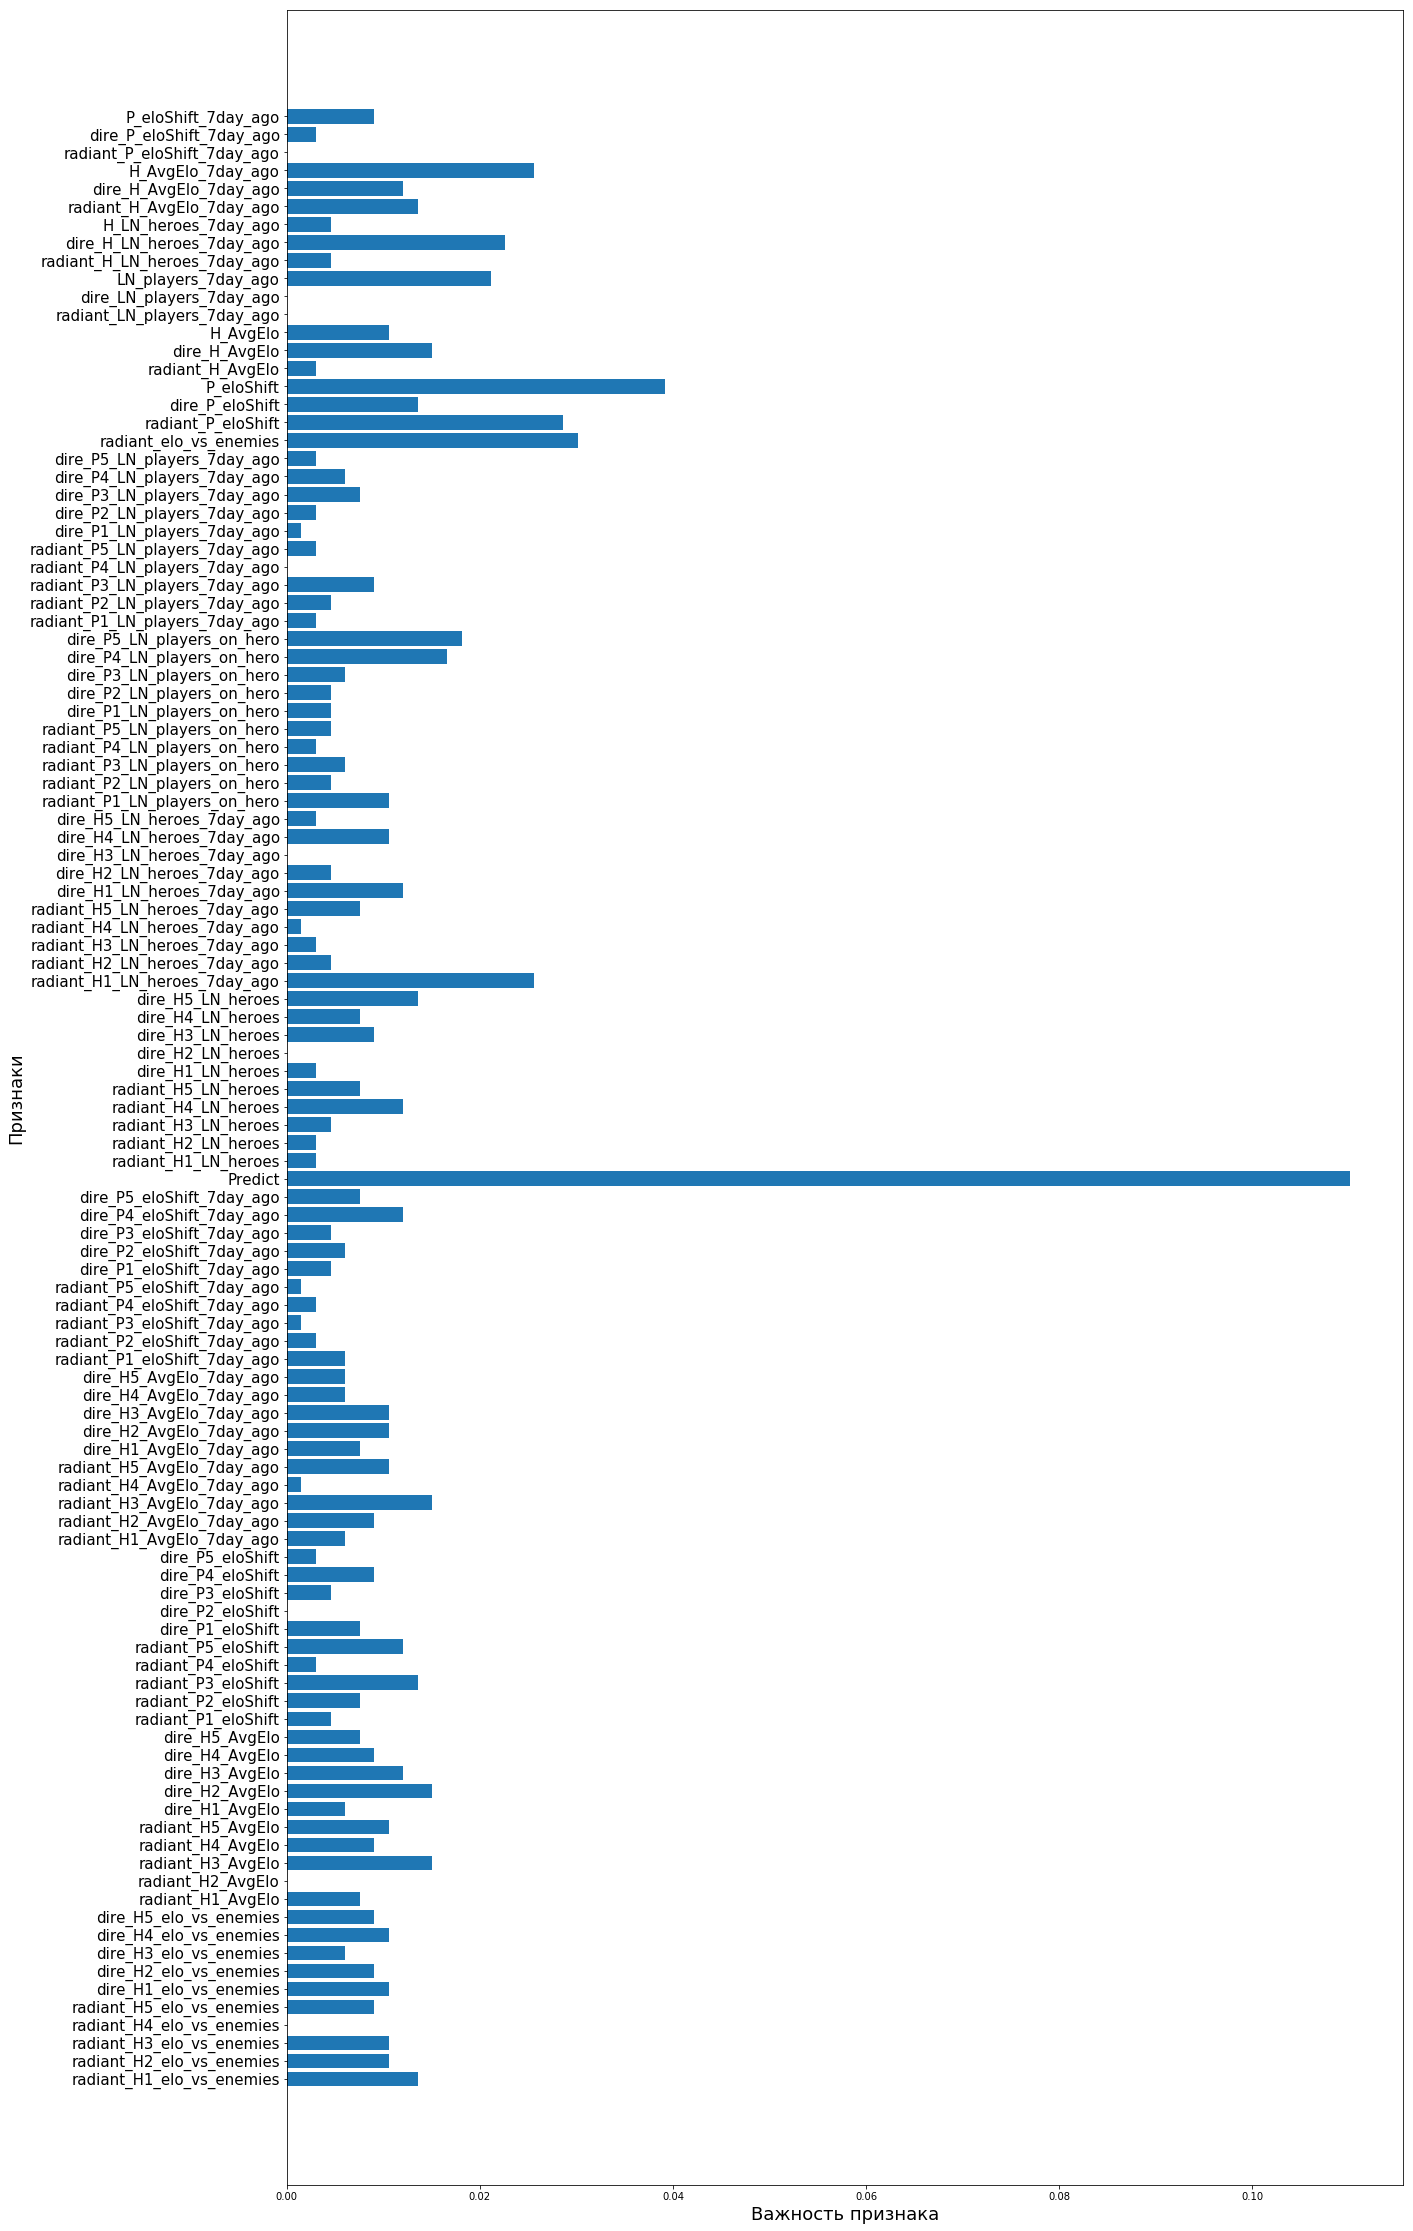

In [80]:
# важность признаков в бустинге

n_features = X_train.shape[1]

plt.figure(figsize=(20,40))
plt.barh(range(n_features), XGB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns, fontsize=15)
plt.xlabel('Важность признака', fontsize=18)
plt.ylabel('Признаки', fontsize=18)
plt.show()

In [115]:
from numpy import sort
thresholds = sort(XGB.feature_importances_)

for thresh in thresholds:
    
    # select features using threshold
    selection = SelectFromModel(XGB, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)

    #train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)

    print(thresh)
    print(classification_report(y_test, selection_model.predict(select_X_test), target_names=['dire_win', 'radiant_win']))


0.0
             precision    recall  f1-score   support

   dire_win       0.68      0.68      0.68       374
radiant_win       0.73      0.74      0.73       442

avg / total       0.71      0.71      0.71       816

0.0
             precision    recall  f1-score   support

   dire_win       0.68      0.68      0.68       374
radiant_win       0.73      0.74      0.73       442

avg / total       0.71      0.71      0.71       816

0.00150602
             precision    recall  f1-score   support

   dire_win       0.68      0.68      0.68       374
radiant_win       0.73      0.74      0.73       442

avg / total       0.71      0.71      0.71       816

0.00150602
             precision    recall  f1-score   support

   dire_win       0.68      0.68      0.68       374
radiant_win       0.73      0.74      0.73       442

avg / total       0.71      0.71      0.71       816

0.00150602
             precision    recall  f1-score   support

   dire_win       0.68      0.68      0.68   

0.0060241
             precision    recall  f1-score   support

   dire_win       0.69      0.71      0.70       374
radiant_win       0.74      0.73      0.74       442

avg / total       0.72      0.72      0.72       816

0.0060241
             precision    recall  f1-score   support

   dire_win       0.69      0.71      0.70       374
radiant_win       0.74      0.73      0.74       442

avg / total       0.72      0.72      0.72       816

0.0060241
             precision    recall  f1-score   support

   dire_win       0.69      0.71      0.70       374
radiant_win       0.74      0.73      0.74       442

avg / total       0.72      0.72      0.72       816

0.0060241
             precision    recall  f1-score   support

   dire_win       0.69      0.71      0.70       374
radiant_win       0.74      0.73      0.74       442

avg / total       0.72      0.72      0.72       816

0.0060241
             precision    recall  f1-score   support

   dire_win       0.69      0.71    

0.0105422
             precision    recall  f1-score   support

   dire_win       0.67      0.69      0.68       374
radiant_win       0.73      0.72      0.73       442

avg / total       0.71      0.70      0.70       816

0.0105422
             precision    recall  f1-score   support

   dire_win       0.67      0.69      0.68       374
radiant_win       0.73      0.72      0.73       442

avg / total       0.71      0.70      0.70       816

0.0105422
             precision    recall  f1-score   support

   dire_win       0.67      0.69      0.68       374
radiant_win       0.73      0.72      0.73       442

avg / total       0.71      0.70      0.70       816

0.0105422
             precision    recall  f1-score   support

   dire_win       0.67      0.69      0.68       374
radiant_win       0.73      0.72      0.73       442

avg / total       0.71      0.70      0.70       816

0.0105422
             precision    recall  f1-score   support

   dire_win       0.67      0.69    

0.0451807
             precision    recall  f1-score   support

   dire_win       0.63      0.63      0.63       374
radiant_win       0.68      0.69      0.68       442

avg / total       0.66      0.66      0.66       816



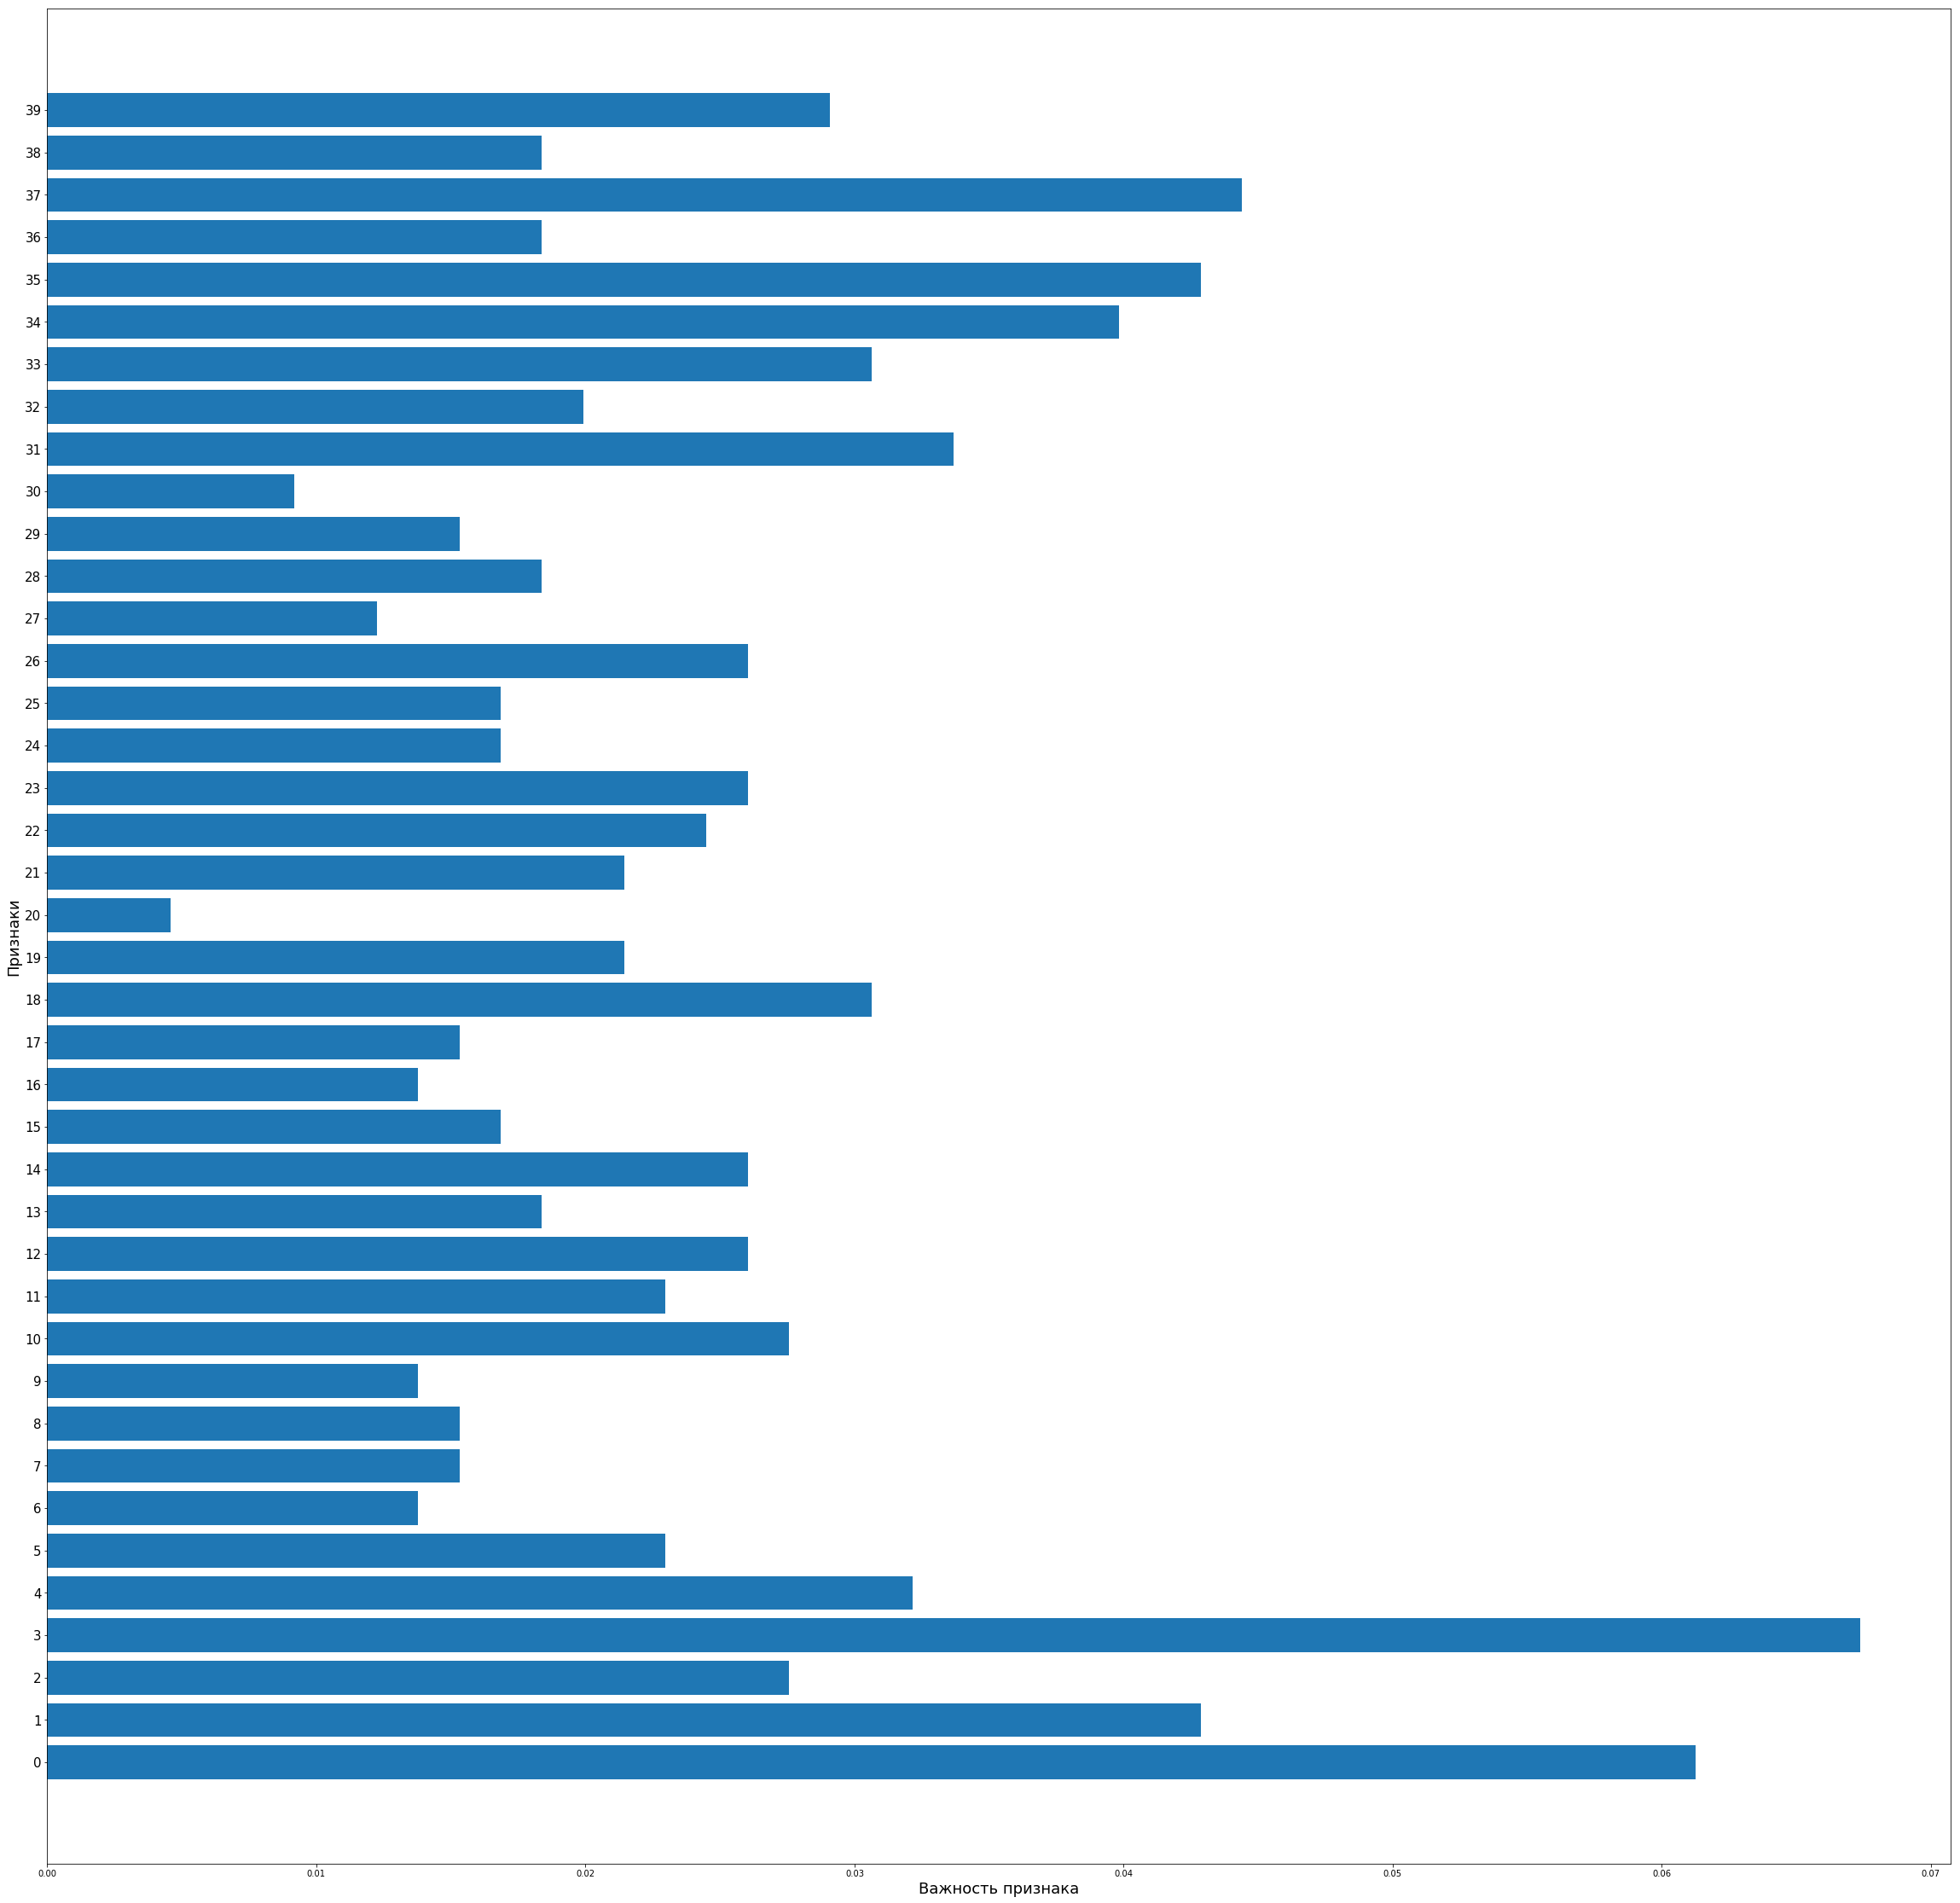

In [114]:
# важность признаков в бустинге

n_features = select_X_train.shape[1]

plt.figure(figsize=(40,40))
plt.barh(range(n_features), selection_model.feature_importances_, align='center')
plt.yticks(np.arange(n_features),  fontsize=15)
plt.xlabel('Важность признака', fontsize=18)
plt.ylabel('Признаки', fontsize=18)
plt.show()

In [206]:
# # save the model to disk
# filename = 'xgb.v.1.3.b.75.sav'
# pickle.dump(XGB, open(filename, 'wb'))

In [258]:
# # Создать и сохранить фичу с предсказаниями по алгоритму, обученому на рейтинге команд
# df_pedict_for_rating_teams = pd.DataFrame(XGB.predict_proba(X)[:,1:], columns=['Predict'])
# df_pedict_for_rating_teams['match_id'] = df_rating_teams_Premium['match_id'].reset_index().drop('index', axis=1)
# df_pedict_for_rating_teams.to_csv('../tabel/table from Datdota/'+
#                            'Predict Pro on 2012-02-28 to 2018-03-01.csv')

In [15]:
# test_gb = pickle.load(open('Xgboost_model_predict_rating_teams', 'rb'))
# test_gb.score(X_test, y_test)

# Решетчатый поиск на Gradient Bosting

In [115]:
%%time
# Праметры GB
# param_grid = {'n_estimators': [25, 50, 100, 150], 'max_depth': [10, 25, 50, 100],
#               'max_features': [50, 100, 200, 300]}
param_grid = {'n_estimators': [100], 'max_depth': [10],
              'max_features': [30]}
grid_search_GB = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1)

grid_search_GB.fit(X_train,y_train)


print("Наилучшие значения параметров: {}".format(grid_search_GB.best_params_))
print('----------------------------------------------------------------------')
print(classification_report(y_test, grid_search_GB.predict(X_test), target_names=['dire_win', 'radiant_win']))

# Проверка на новых данных

In [57]:
# date_contr = '2018-03-01 to 2018-04-08'
# date_contr = '2018-04-08 to 2018-04-25'
date_contr = '2018-03-01 to 2018-06-01'
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium_contr = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'PREMIUM on {} (PreDay).csv'.format(date_contr), index_col=0)

# ДФ с контрпиками
df_contrpick_contr = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-last. on {} (PreDay, All, more 20).csv'.format(date_contr), index_col=0)

# ДФ с метовыми героями 
df_meta_heroes_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on {} (TwoMonthAgo, All, more 20).csv'.format(date_contr), index_col=0)

# # ДФ с сигнатурками для каждого игрока (ALL, >5)
# df_signatures_heroes_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                     'Players Signatures on {} (PreDay, All, more 5).csv'.format(date_contr), index_col=0)

# как герой отыгрывает последние 7 дней
df_meta_7day_ago_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on {} (7DayAgo, All, more 10).csv'.format(date_contr), index_col=0)

# # как игрок играет последние 7 жней
# df_eloShift_players_7day_ago_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                    'EloShift Players on {} (7day_ago, All, more 1).csv'.format(date_contr), index_col=0)

# ДФ с данными KDA по героям за все время с патча 6.88
df_KDA_heroes_contr = pd.read_csv('../tabel/table from Datdota/KDA/Heroes/'+
                            'KDA heroes on {} (6.88+, All, more 20).csv'.format(date_contr), index_col=0)

# ДФ с данными KDA по героям за последние 7 дней
df_KDA_heroes_7day_ago_contr = pd.read_csv('../tabel/table from Datdota/KDA/Heroes/7day_ago/'+
                            'KDA heroes on {} (7day_ago, All, more 10).csv'.format(date_contr), index_col=0)

# ДФ с данными KDA игроков по герою 
df_KDA_players_on_hero_contr = pd.read_csv('../tabel/table from Datdota/KDA/Players/'+
                            'KDA Players on hero {} (All time, All, more 5).csv'.format(date_contr), index_col=0)

# ДФ с данными KDA по игроку за последние 7 дней
df_KDA_players_7day_ago_contr = pd.read_csv('../tabel/table from Datdota/KDA/Players/7day_ago/'+
                            'KDA, EloShift Players on {} (7day_ago, All, more 1).csv'.format(date_contr), index_col=0)


In [58]:
# дф с матчами где по каждому героя своя фича (Премиум)
df_features_Heroes_contr = pd.read_csv('../tabel/table from Datdota/Features Heroes/'+
                                      'PREMIUM on {}.csv'.format(date_contr), index_col=0)
# дф с матчами где фичи тип атаки, дизейблер, нюкер, керри и другие (Премиум)
df_features_type_Heroes_contr = pd.read_csv('../tabel/table from Datdota/Features carry, support, necker/'+
                                      'PREMIUM on {}.csv'.format(date_contr), index_col=0)
# дф с предсказаниями по алгоритму, обученому только на рейтинге команд
df_predict_for_teams_rating_contr = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'Predict for rating teams on {}.csv'.format(date_contr), index_col=0)

In [59]:
df_rating_teams_Premium_contr['league_name'].unique()

array(['EPICENTER XL', 'GESC: Indonesia', 'GESC: Thailand',
       'PGL BUCHAREST MAJOR 2018', 'SL i-League Invitational Season 4',
       'World Electronic Sports Games International',
       'Corsair DreamLeague season 9', 'Dota 2 Asia Championships 2018',
       'StarLadder ImbaTV Invitational Season 5',
       'ESL One Birmingham 2018 powered by Intel',
       'CHINA DOTA2 SUPER MAJOR', 'MDL Changsha'], dtype=object)

In [66]:
df_rating_teams_Premium_contr =df_rating_teams_Premium_contr[df_rating_teams_Premium_contr['league_name'] == 
                                                             'CHINA DOTA2 SUPER MAJOR']
# pd.set_option('display.max_columns', 500)


In [67]:
# df_rating_teams_Premium_contr['radiant_delta7day_elo32'] = (df_rating_teams_Premium_contr['radiant_current_elo32'] - 
#                                                 df_rating_teams_Premium_contr['radiant_sevenDayAgo_elo32'])
# df_rating_teams_Premium_contr['radiant_delta7day_elo64'] = (df_rating_teams_Premium_contr['radiant_current_elo64'] - 
#                                                 df_rating_teams_Premium_contr['radiant_sevenDayAgo_elo64'])

# df_rating_teams_Premium_contr['dire_delta7day_elo32'] = (df_rating_teams_Premium_contr['dire_current_elo32'] - 
#                                                 df_rating_teams_Premium_contr['dire_sevenDayAgo_elo32'])
# df_rating_teams_Premium_contr['dire_delta7day_elo64'] = (df_rating_teams_Premium_contr['dire_current_elo64'] - 
#                                                 df_rating_teams_Premium_contr['dire_sevenDayAgo_elo64'])

# df_rating_teams_Premium_contr['radiant_delta30day_elo32'] = (df_rating_teams_Premium_contr['radiant_current_elo32'] - 
#                                                 df_rating_teams_Premium_contr['radiant_thirtyDayAgo_elo32'])
# df_rating_teams_Premium_contr['radiant_delta30day_elo64'] = (df_rating_teams_Premium_contr['radiant_current_elo64'] - 
#                                                 df_rating_teams_Premium_contr['radiant_thirtyDayAgo_elo64'])

# df_rating_teams_Premium_contr['dire_delta30day_elo32'] = (df_rating_teams_Premium_contr['dire_current_elo32'] - 
#                                                 df_rating_teams_Premium_contr['dire_thirtyDayAgo_elo32'])
# df_rating_teams_Premium_contr['dire_delta30day_elo64'] = (df_rating_teams_Premium_contr['dire_current_elo64'] - 
#                                                 df_rating_teams_Premium_contr['dire_thirtyDayAgo_elo64'])


# Подгрузка данных с Премиум матчей

In [68]:
# # ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
# df_contrpick_premium_contr = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2018-03-01 to 2018-04-08 (PreDay, Pro, more 20).csv', index_col=0)

# # ДФ с метовыми героями (PRO, >10)
# df_meta_heroes_premium_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Meta on 2018-03-01 to 2018-04-08 (TwoMonthAgo, Pro, more 20).csv', index_col=0)

In [69]:
# contr_Premium = get_main_df_for_predict_for_ProTeams(df_rating_teams_Premium_contr,
#                                                     df_contrpick_premium_contr, df_meta_heroes_premium_contr)


In [70]:
# contr_Premium.columns

# Создание обучающих и тестовых данных

In [81]:
contr = get_main_df_for_predict(df_rating_teams_Premium_contr, df_contrpick_contr, df_meta_heroes_contr, 
        df_features_Heroes_contr, df_features_type_Heroes_contr, df_predict_for_teams_rating_contr, df_meta_7day_ago_contr, 
          df_KDA_heroes_contr, df_KDA_heroes_7day_ago_contr, df_KDA_players_on_hero_contr, df_KDA_players_7day_ago_contr)

956
956


C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


In [82]:
# contr = pd.merge(contr, contr_Premium, left_on='match_id', right_on='match_id',how='left')
# contr = pd.merge(contr, df_predict_signatures_contr, left_on='match_id', right_on='match_id',how='left')
contr = contr.dropna()
len(contr)

912

In [83]:
# Создание контрольной выборки
# Cделать обучающие данные и ответы
X_contr = contr.drop(['radiant_win', 'match_id'], axis=1) # ], axis=1) # 
y_contr = contr['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y_contr = y_contr.astype(int)
# X_contr.columns

In [84]:
print(classification_report(y_contr, XGB.predict(X_contr), target_names=['dire_win', 'radiant_win']))
gb_auc = metrics.roc_auc_score(y_contr, XGB.predict_proba(X_contr)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

             precision    recall  f1-score   support

   dire_win       0.63      0.65      0.64       400
radiant_win       0.72      0.70      0.71       512

avg / total       0.68      0.68      0.68       912

AUC для градиентного бустинга - 0.743


In [178]:
# Запись данных предсказаний для проверки
df_predict_signatures_contr = pd.DataFrame(contr['match_id'])
df_predict_signatures_contr['Pred_7day_ago'] = XGB.predict_proba(X_contr)[:,1]

In [147]:
#  precision    recall  f1-score   support

#    dire_win       0.73      0.77      0.75       107
# radiant_win       0.77      0.74      0.76       116

# avg / total       0.75      0.75      0.75       223

# AUC для градиентного бустинга - 0.796
# #          precision    recall  f1-score   support

# #    dire_win       0.58      0.58      0.58       179
# # radiant_win       0.70      0.70      0.70       250

# # avg / total       0.65      0.65      0.65       429

# # AUC для градиентного бустинга - 0.692
# df_predict_signatures_contr = pd.DataFrame(contr['match_id'])
# df_predict_signatures_contr['Pred_signatures'] = XGB.predict_proba(X_contr)[:,1]


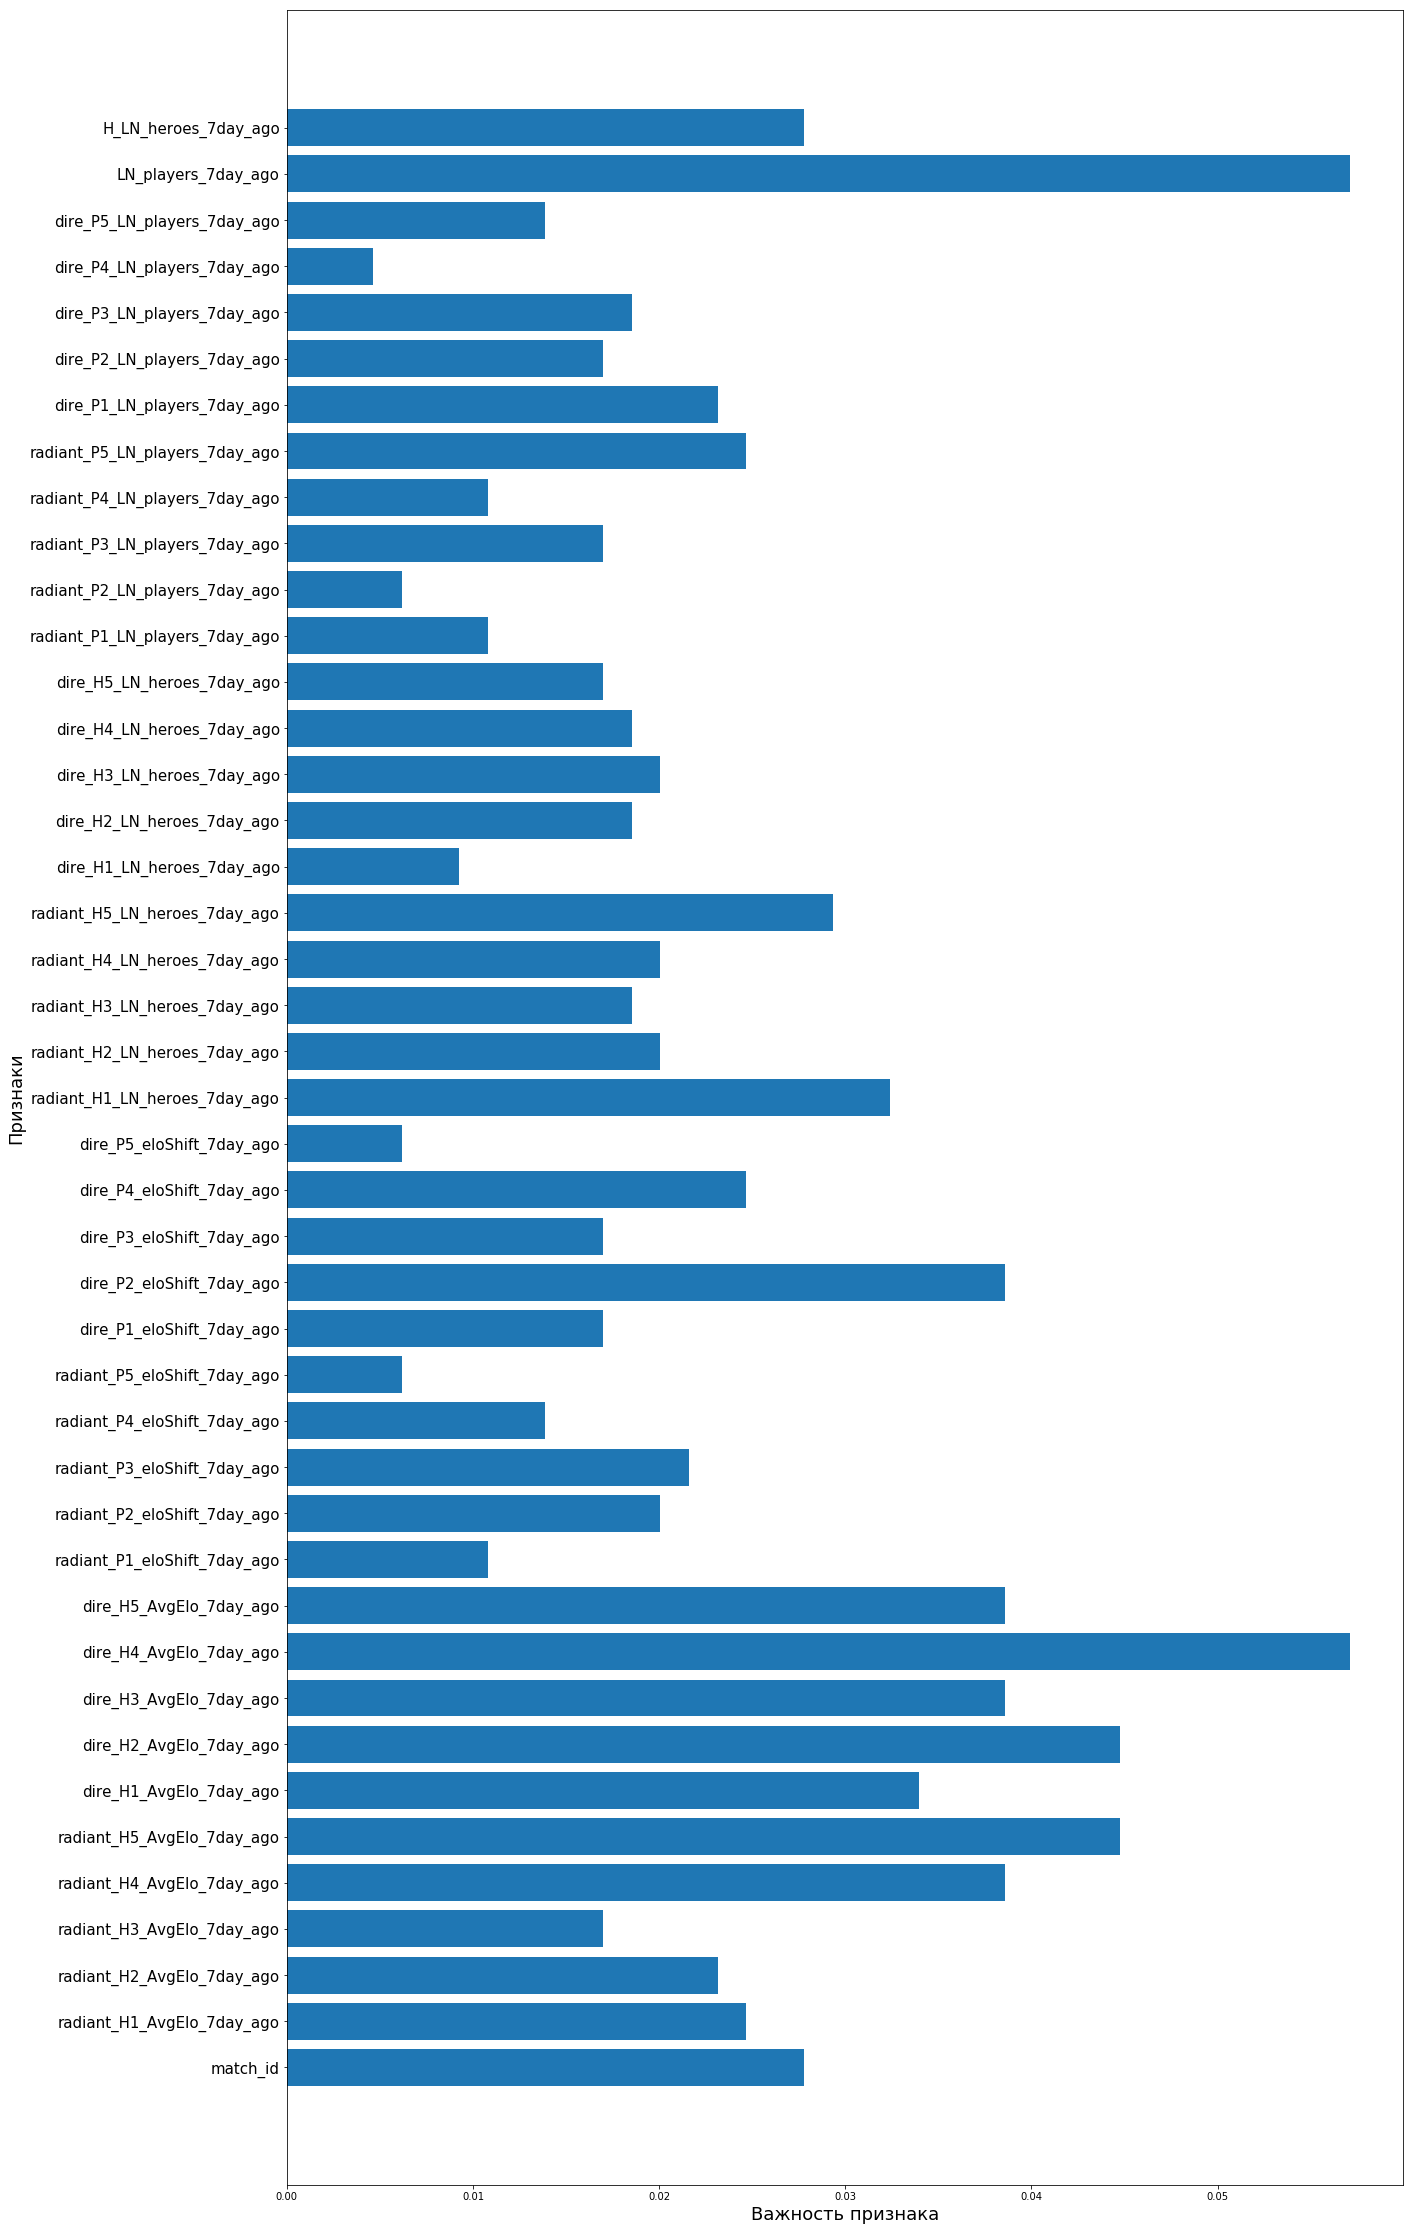

In [228]:
# важность признаков в бустинге

n_features = X_contr.shape[1]

plt.figure(figsize=(20,40))
plt.barh(range(n_features), XGB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_contr.columns, fontsize=15)
plt.xlabel('Важность признака', fontsize=18)
plt.ylabel('Признаки', fontsize=18)
plt.show()

In [334]:
# # Создать и сохранить фичу с предсказаниями по алгоритму, обученому на рейтинге команд
# df_pedict_for_rating_teams = pd.DataFrame(XGB.predict_proba(X_contr)[:,1:], columns=['Predict'])
# df_pedict_for_rating_teams['match_id'] = df_rating_teams_Premium_contr['match_id'].reset_index().drop('index', axis=1)
# df_pedict_for_rating_teams.to_csv('../tabel/table from Datdota/'+
#                            'Predict Pro on 2018-03-01 to 2018-04-08.csv')

# Подгрузка данных по матчам Professional

In [140]:
# # Работа с данными Professional
# # ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
# df_contrpick_Pro = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'Professional data from 6.74-last. on 2012-02-28 to 2018-03-01 (PreDay, All, more 20).csv', index_col=0)
# # ДФ с метовыми героями (PRO, >10)
# df_meta_heroes_Pro = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Professional Meta on 2012-02-28 to 2018-03-01 (TwoMonthAgo, All, more 20).csv', index_col=0)

# # ДФ с сигнатурками для каждого игрока (ALL, >5)
# df_signatures_heroes_Pro = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                    'Professional Players Signatures on 2012-02-28 to 2018-03-01 (All, more 5) (previosly day).csv', index_col=0)

In [141]:
def replace_in_columns_to_mean(df ):
    # Заменить 0.0 во всех колонках на среднее значение
    # посчитать среднее значение для elo игрока
    a = []
    H_or_P = df.columns[0].split('_')[1][0]
    end_name_columns = df.columns[0][( df.columns[0].find('_')+3):]
    for i in range (1,6):
        a.append(df[('radiant_{}{}'+end_name_columns).format(H_or_P, i)].mean())
    #     print(df_contrpick['radiant_H{}elo_vs_enemies'.format(i)].value_counts().head())

        a.append(df[('dire_{}{}'+end_name_columns).format(H_or_P, i)].mean())
    #     print(df_contrpick['dire_H{}elo_vs_enemies'.format(i)].value_counts().head())
    mean_Players = np.array(a).mean()
    print(mean_Players)
    # заменить все значения 0.0 в elo игрока на среднее значение
    for i in range (1,6):
        df[('radiant_{}{}'+end_name_columns).format(H_or_P, i)] = df[('radiant_{}{}'+end_name_columns
                                                            ).format(H_or_P, i)].replace(0, mean_Players)

        df[('dire_{}{}'+end_name_columns).format(H_or_P, i)] = df[('dire_{}{}'+end_name_columns
                                                         ).format(H_or_P, i)].replace(0, mean_Players)  

In [142]:
# replace_in_columns_to_mean(df_signatures_heroes)
# replace_in_columns_to_mean(df_signatures_heroes_Pro, '_eloShift')

In [143]:
# for i in range (1,6):
#         print(df_contrpick['radiant_H{}_elo_vs_enemies'.format(i)].value_counts().head())
#         print(df_contrpick['dire_H{}_elo_vs_enemies'.format(i)].value_counts().head())

In [144]:
# df_signatures_heroes_Pro = df_signatures_heroes_Pro[['radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift', 
#                                             'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift', 
#                                             'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift', 
#                                             'dire_P5_eloShift', 'match_id']].fillna(mean_Players)

# # Соединение всех данных в один ДФ
# main2 = pd.read_csv('../tabel/'+
#                 'Proffesional on patch 7.01 to 2018-03-01 (match_id).csv')
# # main2 = pd.merge(main2, df_contrpick_Pro, left_on='match_id', right_on='match_id',how='left')
# # main2 = pd.merge(main2, df_meta_heroes_Pro, left_on='match_id', right_on='match_id',how='left')
# main2 = pd.merge(main2, df_signatures_heroes_Pro, left_on='match_id', right_on='match_id',how='left')

# # # удаление не нужных колонок для обучения
# main2 = main2.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
#            'dire_score'], axis=1)

# print (len(main2))
# main2.columns

In [145]:
# main = df_signatures_heroes
# print (len(main))
# main.columns

# Старые проверки и работы

# Создание основного ДФ для обучения и предсказания

In [122]:
df_signatures_heroes = df_signatures_heroes[['radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift', 
                                            'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift', 
                                            'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift', 
                                            'dire_P5_eloShift', 'match_id']]

# Соединение всех данных в один ДФ
main = df_rating_teams_Premium
main = pd.merge(main, df_contrpick, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_meta_heroes, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_signatures_heroes, left_on='match_id', right_on='match_id',how='left')

# ---------------------------------------------------------------------------------------------------------------------
# Добавить фичи по геряом и типам героев
# main = pd.merge(main, df_features_type_Heroes, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_features_Heroes, left_on='match_id', right_on='match_id',how='left')
# ---------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------
# Добавить фичи по Professional матчам
# main = pd.merge(main, df_contrpick_Pro10, left_on='match_id', right_on='match_id',how='left')
# main = pd.merge(main, df_contrpick_2MonthAgo_AllTeam1, left_on='match_id', right_on='match_id',how='left')
# ---------------------------------------------------------------------------------------------------------------------

# удаление не нужных колонок для обучения
main = main.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
           'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
main = main.drop(main.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)


# # Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
# main = main.drop(main.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
# main = main.drop(main.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)
# main = main.drop(main.loc[:, 'radiant_ratingSevenDaysAgo_glicko':'radiant_ratingSevenDaysAgo_glicko2'], axis=1)
# main = main.drop(main.loc[:, 'dire_ratingSevenDaysAgo_glicko':'dire_ratingSevenDaysAgo_glicko2'], axis=1)
# Выбросить весь рейтинг команд
main = main.drop(main.loc[:, 'radiant_current_elo32':'dire_ratingSevenDaysAgo_glicko2'], axis=1)

print (len(main))
# main.columns

3602


In [78]:
print(main.loc[2000, "radiant_rating_glicko2"])
datetime.date.fromtimestamp(1506788216)

1728.34025281


datetime.date(2017, 9, 30)

In [102]:
df_signatures_heroes[df_signatures_heroes['match_id']== 3475124948].loc[:, :]

,radiant_P1_eloShift,radiant_P2_eloShift,radiant_P3_eloShift,radiant_P4_eloShift,radiant_P5_eloShift,dire_P1_eloShift,dire_P2_eloShift,dire_P3_eloShift,dire_P4_eloShift,dire_P5_eloShift,match_id
2000,3.795196,-4.318838,0.0,-5.28387,0.0,0.0,0.0,4.273999,2.530319,-11.045056,3475124948


In [124]:
# Заполнить пустые значения на 0
# main = main.fillna(0)

main['Predict'] = predict_for_rating_teams
# убрать пустые ячейки
main = main.dropna()
len(main)

3452

In [125]:
main.columns

Index(['radiant_win', 'radiant_H1_elo_vs_enemies', 'radiant_H2_elo_vs_enemies',
       'radiant_H3_elo_vs_enemies', 'radiant_H4_elo_vs_enemies',
       'radiant_H5_elo_vs_enemies', 'dire_H1_elo_vs_enemies',
       'dire_H2_elo_vs_enemies', 'dire_H3_elo_vs_enemies',
       'dire_H4_elo_vs_enemies',
       ...
       'Underlord', 'Terrorblade', 'Phoenix', 'Oracle', 'Winter Wyvern',
       'Arc Warden', 'Monkey King', 'Dark Willow', 'Pangolier', 'Predict'],
      dtype='object', length=147)

In [127]:
# Создаем новые колонуи по суммам, разности показателей
main['radiant_elo_vs_enemies'] = (main['radiant_H1_elo_vs_enemies'] + main['radiant_H2_elo_vs_enemies'] + 
                main['radiant_H3_elo_vs_enemies'] + main['radiant_H4_elo_vs_enemies'] + main['radiant_H5_elo_vs_enemies'])

# main['dire_elo_vs_enemies'] = (main['dire_H1_elo_vs_enemies'] + main['dire_H2_elo_vs_enemies'] + 
#                             main['dire_H3_elo_vs_enemies'] + main['dire_H4_elo_vs_enemies'] + main['dire_H5_elo_vs_enemies'])

# main['elo_vs_enemies'] = main['radiant_elo_vs_enemies'] - main['dire_elo_vs_enemies']
# main = main.drop(['radiant_elo_vs_enemies', 'dire_elo_vs_enemies'], axis=1)

main['radiant_P_eloShift'] = (main['radiant_P1_eloShift'] + main['radiant_P2_eloShift'] + 
                              main['radiant_P3_eloShift'] + main['radiant_P4_eloShift'] + main['radiant_P5_eloShift'])

main['dire_P_eloShift'] = (main['dire_P1_eloShift'] + main['dire_P2_eloShift'] + 
                           main['dire_P3_eloShift'] + main['dire_P4_eloShift'] + main['dire_P5_eloShift'])

main['P_eloShift'] = main['radiant_P_eloShift'] - main['dire_P_eloShift']

# main = main.drop(['radiant_P_eloShift', 'dire_P_eloShift'], axis=1)

C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [128]:
main['radiant_H_AvgElo'] = (main['radiant_H1_AvgElo'] + main['radiant_H2_AvgElo'] + 
                              main['radiant_H3_AvgElo'] + main['radiant_H4_AvgElo'] + main['radiant_H5_AvgElo'])

main['dire_H_AvgElo'] = (main['dire_H1_AvgElo'] + main['dire_H2_AvgElo'] + 
                           main['dire_H3_AvgElo'] + main['dire_H4_AvgElo'] + main['dire_H5_AvgElo'])

main['H_AvgElo'] = main['radiant_H_AvgElo'] - main['dire_H_AvgElo']

# main = main.drop(['dire_H_AvgElo', 'radiant_H_AvgElo'], axis=1)

C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [129]:
main['Disabler'] = (main['Disabler1'] + main['Disabler2'] + main['Disabler3'] + main['Disabler4'] + main['Disabler5'] - 
                   main['Disabler6'] - main['Disabler7'] - main['Disabler8'] - main['Disabler9'] - main['Disabler10'])

main['Nuker'] = (main['Nuker1'] + main['Nuker2'] + main['Nuker3'] + main['Nuker4'] + main['Nuker5'] - 
                   main['Nuker6'] - main['Nuker7'] - main['Nuker8'] - main['Nuker9'] - main['Nuker10'])

main['Carry'] = (main['Carry1'] + main['Carry2'] + main['Carry3'] + main['Carry4'] + main['Carry5'] - 
                   main['Carry6'] - main['Carry7'] - main['Carry8'] - main['Carry9'] - main['Carry10'])

main['Initiator'] = (main['Initiator1'] + main['Initiator2'] + main['Initiator3'] + main['Initiator4'] + main['Initiator5'] - 
                   main['Initiator6'] - main['Initiator7'] - main['Initiator8'] - main['Initiator9'] - main['Initiator10'])

main['Escape'] = (main['Escape1'] + main['Escape2'] + main['Escape3'] + main['Escape4'] + main['Escape5'] - 
                   main['Escape6'] - main['Escape7'] - main['Escape8'] - main['Escape9'] - main['Escape10'])

main['Durable'] = (main['Durable1'] + main['Durable2'] + main['Durable3'] + main['Durable4'] + main['Durable5'] - 
                   main['Durable6'] - main['Durable7'] - main['Durable8'] - main['Durable9'] - main['Durable10'])

main['Support'] = (main['Support1'] + main['Support2'] + main['Support3'] + main['Support4'] + main['Support5'] - 
                   main['Support6'] - main['Support7'] - main['Support8'] - main['Support9'] - main['Support10'])

main['Pusher'] = (main['Pusher1'] + main['Pusher2'] + main['Pusher3'] + main['Pusher4'] + main['Pusher5'] - 
                   main['Pusher6'] - main['Pusher7'] - main['Pusher8'] - main['Pusher9'] - main['Pusher10'])

main['Jungler'] = (main['Jungler1'] + main['Jungler2'] + main['Jungler3'] + main['Jungler4'] + main['Jungler5'] - 
                   main['Jungler6'] - main['Jungler7'] - main['Jungler8'] - main['Jungler9'] - main['Jungler10'])
main = main.drop(['attac_type1','Disabler1','Nuker1','Carry1','Initiator1','Escape1','Durable1','Support1','Pusher1','Jungler1',
           'attac_type2','Disabler2','Nuker2','Carry2','Initiator2','Escape2','Durable2','Support2','Pusher2','Jungler2',
           'attac_type3','Disabler3','Nuker3','Carry3','Initiator3','Escape3','Durable3','Support3','Pusher3','Jungler3',
           'attac_type4','Disabler4','Nuker4','Carry4','Initiator4','Escape4','Durable4','Support4','Pusher4','Jungler4',
           'attac_type5','Disabler5','Nuker5','Carry5','Initiator5','Escape5','Durable5','Support5','Pusher5','Jungler5',
           'attac_type6','Disabler6','Nuker6','Carry6','Initiator6','Escape6','Durable6','Support6','Pusher6','Jungler6',
           'attac_type7','Disabler7','Nuker7','Carry7','Initiator7','Escape7','Durable7','Support7','Pusher7','Jungler7',
           'attac_type8','Disabler8','Nuker8','Carry8','Initiator8','Escape8','Durable8','Support8','Pusher8','Jungler8',
           'attac_type9','Disabler9','Nuker9','Carry9','Initiator9','Escape9','Durable9','Support9','Pusher9','Jungler9',
     'attac_type10','Disabler10','Nuker10','Carry10','Initiator10','Escape10','Durable10','Support10','Pusher10','Jungler10'], axis=1)

KeyError: 'Disabler1'

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
main['Disabler'] = scaler.fit(pd.DataFrame(main['Disabler'])).transform(pd.DataFrame(main['Disabler']))
main['Nuker'] = scaler.fit(pd.DataFrame(main['Nuker'])).transform(pd.DataFrame(main['Nuker']))
main['Carry'] = scaler.fit(pd.DataFrame(main['Carry'])).transform(pd.DataFrame(main['Carry']))
main['Initiator'] = scaler.fit(pd.DataFrame(main['Initiator'])).transform(pd.DataFrame(main['Initiator']))
main['Escape'] = scaler.fit(pd.DataFrame(main['Escape'])).transform(pd.DataFrame(main['Escape']))
main['Durable'] = scaler.fit(pd.DataFrame(main['Durable'])).transform(pd.DataFrame(main['Durable']))
main['Support'] = scaler.fit(pd.DataFrame(main['Support'])).transform(pd.DataFrame(main['Support']))
main['Pusher'] = scaler.fit(pd.DataFrame(main['Pusher'])).transform(pd.DataFrame(main['Pusher']))
main['Jungler'] = scaler.fit(pd.DataFrame(main['Jungler'])).transform(pd.DataFrame(main['Jungler']))

In [69]:
main.columns

Index(['radiant_win', 'radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_sigma_glicko',
       'radiant_mu_glicko2', 'radiant_phi_glicko2', 'radiant_rating_glicko2',
       'radiant_ratingSevenDaysAgo_glicko2', 'dire_mu_glicko',
       ...
       'H_AvgElo', 'Disabler', 'Nuker', 'Carry', 'Initiator', 'Escape',
       'Durable', 'Support', 'Pusher', 'Jungler'],
      dtype='object', length=178)

In [106]:
main['mu_glicko'] = main['radiant_mu_glicko'] -  main['dire_mu_glicko']
main['rating_glicko'] = main['radiant_rating_glicko'] -  main['dire_rating_glicko']
main['ratingSevenDaysAgo_glicko'] = main['radiant_ratingSevenDaysAgo_glicko'] -  main['dire_ratingSevenDaysAgo_glicko']
main['mu_glicko2'] = main['radiant_mu_glicko2'] -  main['dire_mu_glicko2']
main['phi_glicko2'] = main['radiant_phi_glicko2'] -  main['dire_phi_glicko2']
# main['rating_glicko2'] = main['radiant_rating_glicko2'] -  main['dire_rating_glicko2']
# main['ratingSevenDaysAgo_glicko2'] = main['radiant_ratingSevenDaysAgo_glicko2'] -  main['dire_ratingSevenDaysAgo_glicko2']
main = main.drop([#'Jungler', 'Pusher', 'Initiator', 'Escape', 'Nuker',
                  # 'radiant_mu_glicko', 'dire_mu_glicko', 
                  # 'radiant_rating_glicko', 'dire_rating_glicko', 
                   'radiant_sigma_glicko', #'dire_sigma_glicko',
                  # 'radiant_ratingSevenDaysAgo_glicko', 'dire_ratingSevenDaysAgo_glicko',
                  # 'radiant_mu_glicko2', 'dire_mu_glicko2', 
                   'radiant_phi_glicko2', 'dire_phi_glicko2',
                   'radiant_rating_glicko2', 'dire_rating_glicko2', 
                  # 'radiant_sigma_glicko2', 'dire_sigma_glicko2',
                   'radiant_ratingSevenDaysAgo_glicko2', #'dire_ratingSevenDaysAgo_glicko2',
                  #'dire_H5_AvgElo', 'radiant_H1_AvgElo'
                 ], axis=1)

In [84]:
# main['radiant_elo_vs_enemies'] = scaler.fit(pd.DataFrame(main['radiant_elo_vs_enemies'])).transform(pd.DataFrame(main['radiant_elo_vs_enemies']))       
# main['radiant_P_eloShift'] = scaler.fit(pd.DataFrame(main['radiant_P_eloShift'])).transform(pd.DataFrame(main['radiant_P_eloShift']))
# main['dire_P_eloShift'] = scaler.fit(pd.DataFrame(main['dire_P_eloShift'])).transform(pd.DataFrame(main['dire_P_eloShift']))
# main['P_eloShift'] = scaler.fit(pd.DataFrame(main['P_eloShift'])).transform(pd.DataFrame(main['P_eloShift']))
# main['radiant_H_AvgElo'] = scaler.fit(pd.DataFrame(main['radiant_H_AvgElo'])).transform(pd.DataFrame(main['radiant_H_AvgElo']))
# main['dire_H_AvgElo'] = scaler.fit(pd.DataFrame(main['dire_H_AvgElo'])).transform(pd.DataFrame(main['dire_H_AvgElo']))
# main['H_AvgElo'] = scaler.fit(pd.DataFrame(main['H_AvgElo'])).transform(pd.DataFrame(main['H_AvgElo']))
# main['mu_glicko'] = scaler.fit(pd.DataFrame(main['mu_glicko'])).transform(pd.DataFrame(main['mu_glicko']))
# main['rating_glicko'] = scaler.fit(pd.DataFrame(main['rating_glicko'])).transform(pd.DataFrame(main['rating_glicko']))
# main['ratingSevenDaysAgo_glicko'] = scaler.fit(pd.DataFrame(main['ratingSevenDaysAgo_glicko'])).transform(pd.DataFrame(main['ratingSevenDaysAgo_glicko']))
# main['mu_glicko2'] = scaler.fit(pd.DataFrame(main['mu_glicko2'])).transform(pd.DataFrame(main['mu_glicko2']))
# main['phi_glicko2'] = scaler.fit(pd.DataFrame(main['phi_glicko2'])).transform(pd.DataFrame(main['phi_glicko2']))

In [85]:
main.columns

Index(['radiant_win', 'radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_mu_glicko2',
       'dire_mu_glicko', 'dire_rating_glicko',
       'dire_ratingSevenDaysAgo_glicko', 'dire_sigma_glicko',
       'dire_mu_glicko2',
       ...
       'dire_P_eloShift', 'P_eloShift', 'radiant_H_AvgElo', 'dire_H_AvgElo',
       'H_AvgElo', 'mu_glicko', 'rating_glicko', 'ratingSevenDaysAgo_glicko',
       'mu_glicko2', 'phi_glicko2'],
      dtype='object', length=168)

In [ ]:
model = XGB

# Проверка правильности данных

In [26]:
# main.loc[1500, 'radiant_H1elo_vs_enemies':]

In [15]:
import datetime
datetime.date.fromtimestamp(1502233763) - datetime.timedelta(1)

datetime.date(2017, 8, 8)

In [ ]:
df_meta_heroes[df_meta_heroes['match_id'] == 3274564960]

# Работа с фичами

In [82]:
best_GB = XGB
# предсказания
predict_GB = best_GB.predict(X_test)
# матрица ошибок
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predict_GB)
confusion

array([[299, 137],
       [127, 338]], dtype=int64)

In [83]:
gb_auc = metrics.roc_auc_score(y_test, best_GB.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

AUC для градиентного бустинга - 0.768


In [75]:
# f1-мера
from sklearn.metrics import f1_score
f1_score(y_test, predict_GB)

0.59335624284077892

In [144]:

print(classification_report(y_test, predict_GB, target_names=['dire_win', 'radiant_win']))

             precision    recall  f1-score   support

   dire_win       0.68      0.66      0.67       436
radiant_win       0.69      0.72      0.70       465

avg / total       0.69      0.69      0.69       901



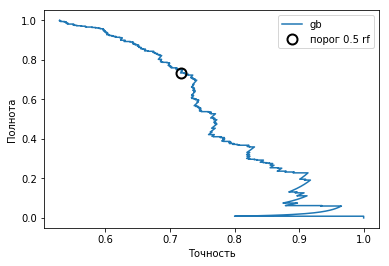

In [65]:
# в RandomForestClassifier есть predict_proba, но нет decision_function
precision_gb, recall_gb, thresholds_gb = metrics.precision_recall_curve(
y_test, best_GB.predict_proba(X_test)[:, 1])

plt.plot(precision_gb, recall_gb, label="gb")
close_default_gb = np.argmin(np.abs(thresholds_gb - 0.5))
plt.plot(precision_gb[close_default_gb], recall_gb[close_default_gb], 'o', c='k',
         markersize=10, label="порог 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")
plt.show()

In [69]:
y_pred_lower_threshold = best_GB.predict_proba(X_test)[:,1] > .5
print (classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       0.71      0.69      0.70       436
          1       0.72      0.73      0.72       465

avg / total       0.71      0.71      0.71       901



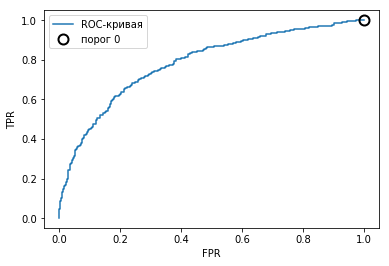

In [60]:
fpr, tpr, threshold = metrics.roc_curve(y_test, best_GB.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
# находим пороговое значение ближайшее к нулю
close_zero = np.argmin(np.abs(threshold))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='порог 0', fillstyle='none', c='k', mew=2)
plt.legend(loc='best')
plt.show()

AUC для градиентного бустинга - 0.775


# Оценка качества признаков

In [150]:
# используем f_classif (по умолчанию)
# и SelectPercentile, чтобы выбрать 50% признаков
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)

print("форма массива X_train: {}".format(X_train.shape))
print("форма массива X_train_selected: {}".format(X_train_selected.shape))

форма массива X_train: (2701, 46)
форма массива X_train_selected: (2701, 23)


In [91]:
mask = select.get_support()
print (mask)
# визуализируем булевы значения: черный - true, булый - false
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Индекс')

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False  True False  True False
  True  True False False False False False False False False False False
  True  True  True  True False  True  True  True False False False False
 False False False False  True False False False  True  True False  True
  True False False False  True False False  True False  True  True  True
 False False False False]


Text(0.5,0,'Индекс')

In [92]:
X_test_selected = select.transform(X_test)
print ('Правильность со всеми признаками: {:.3f}'.format(best_GB.score(X_test, y_test)))
best_GB_selected_70 = xgb.XGBClassifier(max_depth=20)
best_GB_selected_70.fit(X_train_selected, y_train)
print ('Правильность с 50% признаками: {:.3f}'.format(best_GB_selected_70.score(X_test_selected, y_test)))

Правильность со всеми признаками: 0.690
Правильность с 50% признаками: 0.681
